In [2]:
import numpy as np
import pandas as pd
from datetime import date
from functools import reduce
import warnings
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

warnings.filterwarnings('ignore')

## Datasets Used

In the `data` folder, we include a `datasets_used.csv` to keep track of the datasets we find useful. Many datasets are updated regulary, so we also include the date we retrieved the dataset for better reproducibility. If the dataset is provided on Github, we include the link to the specific version we are using.

| name | local_path | url | date_retrieved | 
| :-- | :--- | :--- | :--- | 
| `covid-tracking-states-current` | covid-tracking/states_current.csv | https://github.com/COVID19Tracking/covid-tracking-data/blob/05363f00ed663709c54b066722094f966dddd1bc/data/states_current.csv  | 2020-04-23 |
| `covid-tracking-states-daily` | covid-tracking/states_daily_4pm_et.csv | https://github.com/COVID19Tracking/covid-tracking-data/blob/2929c4f3642b31f154b9bf314df16c6a023eecd2/data/states_daily_4pm_et.csv | 2020-05-07 | 
| `covid-tracking-us-current` | covid-tracking/us_current.csv | https://github.com/COVID19Tracking/covid-tracking-data/blob/05363f00ed663709c54b066722094f966dddd1bc/data/us_current.csv | 2020-04-23 | 
| `covid-tracking-us-daily` | covid-tracking/us_daily.csv | https://github.com/COVID19Tracking/covid-tracking-data/blob/05363f00ed663709c54b066722094f966dddd1bc/data/us_daily.csv | 2020-04-23 | 
| `khn-icu-beds-by-county` | khn/data-FPBfZ.csv  | https://khn.org/news/as-coronavirus-spreads-widely-millions-of-older-americans-live-in-counties-with-no-icu-beds/ | 2020-04-21 | 
| `khn-hospital-by-county` | khn/KHN_ICU_bed_county_analysis_2.csv | https://khn.org/wp-content/uploads/sites/2/2020/03/KHN-ICU-bed-county-analysis_2.zip | 2020-04-21 | 
| `kff-state-actions`| kff/raw_data.csv | https://www.kff.org/health-costs/issue-brief/state-data-and-policy-actions-to-address-coronavirus/#stateleveldata  | 2020-04-24  |
| `kff-state-actions`| kff/raw_data_0504.csv | https://www.kff.org/health-costs/issue-brief/state-data-and-policy-actions-to-address-coronavirus/#stateleveldata  | 2020-05-04  |
| `kff-state-health-policy-actions` | kff/health_policy_actions.csv | https://www.kff.org/health-costs/issue-brief/state-data-and-policy-actions-to-address-coronavirus/#stateleveldata | 2020-04-10 |
| `kff-state-actions-policy-date`| kff/response_policy_date.csv | https://www.kff.org/report-section/state-data-and-policy-actions-to-address-coronavirus-sources/  | 2020-04-24  |
| `wiki-state-regulations` | wiki/state_regulations | https://en.m.wikipedia.org/wiki/U.S._state_and_local_government_response_to_the_2020_coronavirus_pandemic | 2020-04-24 |
| `world-bank-hospital-beds`  | world-bank/API_SH.MED.BEDS.ZS_DS2_en_csv_v2_988924.csv | https://data.worldbank.org/indicator/SH.MED.BEDS.ZS  | 2020-04-24 |
| `world-bank-physicians` | world-bank/API_SH.MED.PHYS.ZS_DS2_en_csv_v2_993645.csv | https://data.worldbank.org/indicator/SH.MED.PHYS.ZS | 2020-04-24 | 
| `world-bank-nurses` | world-bank/API_SH.MED.NUMW.P3_DS2_en_csv_v2_993722.csv | https://data.worldbank.org/indicator/SH.MED.NUMW.P3 | 2020-04-24 | 
| `world-bank-specialist-surgical-workforce` | world-bank/API_SH.MED.SAOP.P5_DS2_en_csv_v2_993706.csv | https://data.worldbank.org/indicator/SH.MED.SAOP.P5 | 2020-04-24 | 
| `world-bank-elderly-population` | world-bank/API_SP.POP.65UP.TO.ZS_DS2_en_csv_v2_988979.csv | https://data.worldbank.org/indicator/SP.POP.65UP.TO.ZS?view=chart | 2020-04-24 | 
| `oxford-government-responses` | oxford/OxCGRT_latest.csv | https://github.com/OxCGRT/covid-policy-tracker/blob/cc78ed82fb68bfce3a7ef583d28f7dc6a58dc8c2/data/OxCGRT_latest.csv | 2020-05-08 | 
| `jhu-global-confirmed` | jhu-csse/time_series_covid19_confirmed_global.csv | https://github.com/CSSEGISandData/COVID-19/blob/fef4e485ca4d46cd05deb5dc3a8e74e806bc9364/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv | 2020-04-24 | 
| `jhu-global-recovered` | jhu-csse/time_series_covid19_recovered_global.csv | https://github.com/CSSEGISandData/COVID-19/blob/fef4e485ca4d46cd05deb5dc3a8e74e806bc9364/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv | 2020-04-24 | 
| `jhu-global-death` | jhu-csse/time_series_covid19_deaths_global.csv | https://github.com/CSSEGISandData/COVID-19/blob/fef4e485ca4d46cd05deb5dc3a8e74e806bc9364/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv    | 2020-04-24 | 
| `population-density-state` | population-density/population_density_state-level.csv | https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population_density    | 2020-05-04 | 
| `population-density-country` | population-density/population_density_country-level.csv | https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population_density    | 2020-05-04 | 

We kept the original name of the datasets, and only performed necessary actions:

- All dataset from World Bank have metadata at the top (line 1-4). We removed those lines.
- `kff/raw_data.csv` includes some extra information in the spreadsheet (line 1-2, 56-71), which cause errors. We removed those lines from the table.We removed some lines from the `kff/raw_data_05-04.csv` and `kff/health_policy_actions.csv` for the same reason.

# Processing Country Level Data

At the country level, we are creating two tables `country_indicators.csv` and `country_responses.csv`. For the first table, we will collect the following information for each country:

| name  | meaning  | source  |
| :---- | :------- | :------ |
| `country_name` | the name of the country/region | `world-bank-hospital-beds` |
| `country_code` | the ISO 3 country code | `world-bank-hospital-beds` |
| `hospital_beds_per_1000` | number of hospital beds per 1000 people          |`world-bank-hospital-beds`     |
| `physicians_per_1000`   | number of physicians per 1000 people            |`world-bank-physicians`       |
| `nurses_per_1000`      | number of nurses and midwives per 1000 people      |`world-bank-nurses`          |
| `percentage_65up`      | population ages 65 and above (% of total population) |`world-bank-elderly-population`  |

In [3]:
# extract indicator SH.MED.BEDS.ZScountry_responses
hospital_beds_df = pd.read_csv('./data/world-bank/API_SH.MED.BEDS.ZS_DS2_en_csv_v2_988924.csv')

latest_numbers = []
for idx, row in hospital_beds_df.iterrows():
    latest = np.nan
    for y in range(2019,1959, -1):
        if pd.notnull(row[str(y)]):
            latest = row[str(y)]
            break
    latest_numbers.append(latest)

hospital_beds_df['hospital_beds_per_1000'] = pd.Series(latest_numbers)
hospital_beds = hospital_beds_df[['Country Name', 'hospital_beds_per_1000']]

hospital_beds.head(3)

,Country Name,hospital_beds_per_1000
0,Aruba,NaN
1,Afghanistan,0.5
2,Angola,0.8


In [4]:
# extract indicator SH.MED.PHYS.ZS
physicians_df = pd.read_csv('./data/world-bank/API_SH.MED.PHYS.ZS_DS2_en_csv_v2_993645.csv')

latest_numbers = []
for idx, row in physicians_df.iterrows():
    latest = np.nan
    for y in range(2019,1959, -1):
        if pd.notnull(row[str(y)]):
            latest = row[str(y)]
            break
    latest_numbers.append(latest)

physicians_df['physicians_per_1000'] = pd.Series(latest_numbers)
physicians = physicians_df[['Country Name', 'physicians_per_1000']]

physicians.head(3)

,Country Name,physicians_per_1000
0,Aruba,1.1200
1,Afghanistan,0.2840
2,Angola,0.2149


In [5]:
# extract indicator SH.MED.NUMW.P3
nurses_df = pd.read_csv('./data/world-bank/API_SH.MED.NUMW.P3_DS2_en_csv_v2_993722.csv')

latest_numbers = []
for idx, row in nurses_df.iterrows():
    latest = np.nan
    for y in range(2019,1959, -1):
        if pd.notnull(row[str(y)]):
            latest = row[str(y)]
            break
    latest_numbers.append(latest)

nurses_df['nurses_per_1000'] = pd.Series(latest_numbers)
nurses = nurses_df[['Country Name', 'nurses_per_1000']]

nurses.head(3)

,Country Name,nurses_per_1000
0,Aruba,NaN
1,Afghanistan,0.3200
2,Angola,1.3123


In [6]:
# extract indicator SP.POP.65UP.TO.ZS
elders_df = pd.read_csv('./data/world-bank/API_SP.POP.65UP.TO.ZS_DS2_en_csv_v2_988979.csv')

latest_numbers = []
for idx, row in elders_df.iterrows():
    latest = np.nan
    for y in range(2019,1959, -1):
        if pd.notnull(row[str(y)]):
            latest = row[str(y)]
            break
    latest_numbers.append(latest)

elders_df['percentage_65up'] = pd.Series(latest_numbers)
elders = elders_df[['Country Name', 'percentage_65up']]

elders.head(3)

,Country Name,percentage_65up
0,Aruba,13.550947
1,Afghanistan,2.584927
2,Angola,2.216374


In [7]:
# collect ISO 3 codes for each country
ISO3 = hospital_beds_df[['Country Name', 'Country Code']]
ISO3.head(3)

,Country Name,Country Code
0,Aruba,ABW
1,Afghanistan,AFG
2,Angola,AGO


In [8]:
#collect the population density of country
def convert_to_float(column):
    x = column.split(",")
    return ''.join(x)
pop_density_df = pd.read_csv('./data/population-density/population_density_country-level.csv')

pop_density_df = pop_density_df[['Country (or dependent territory)', 'Density_pop./km2']]

pop_density_df['Density_pop./km2']= pop_density_df['Density_pop./km2'].map(lambda x:convert_to_float(x))


pop_density = pop_density_df.rename(columns={
    'Country (or dependent territory)': 'Country Name', 
    'Density_pop./km2': 'population_density_km2'
})

pop_density.astype({'population_density_km2': 'float64'})

,Country Name,population_density_km2
0,Mongolia,1.90
1,Namibia,2.90
2,Australia,3.00
3,Iceland,3.50
4,Suriname,3.50
...,...,...
248,Western Sahara[note 12],2.30
249,Pitcairn Islands (United Kingdom),1.20
250,Falkland Islands (United Kingdom),0.21
251,Svalbard and Jan Mayen (Norway),0.04


After collecting all the pieces, we can now merge them and output to the output directory (`processed_data`).

In [9]:

# merge dataframes together by country name
data_frames = [ISO3, hospital_beds, physicians, nurses, elders, pop_density]
df_merged = reduce(lambda left, right: pd.merge(left, right, how='inner',on=['Country Name']), data_frames)

# rename columns names for consistency
df_merged.rename(columns={
    'Country Name': 'country_name', 
    'Country Code': 'country_code'
}, inplace=True)

df_merged.head(3)

,country_name,country_code,hospital_beds_per_1000,physicians_per_1000,nurses_per_1000,percentage_65up,population_density_km2
0,Afghanistan,AFG,0.5,0.2840,0.3200,2.584927,49
1,Angola,AGO,0.8,0.2149,1.3123,2.216374,23
2,Albania,ALB,2.9,1.1998,3.5998,13.744736,100


In [10]:
df_merged['hospital_resource_index'] =  df_merged['hospital_beds_per_1000'] + df_merged['physicians_per_1000'] + df_merged['nurses_per_1000']
df_merged_country = df_merged.fillna(0)
df_merged_country.head(3)

,country_name,country_code,hospital_beds_per_1000,physicians_per_1000,nurses_per_1000,percentage_65up,population_density_km2,hospital_resource_index
0,Afghanistan,AFG,0.5,0.2840,0.3200,2.584927,49,1.1040
1,Angola,AGO,0.8,0.2149,1.3123,2.216374,23,2.3272
2,Albania,ALB,2.9,1.1998,3.5998,13.744736,100,7.6996


In [11]:
# write to output file in processed_data folder
df_merged.to_csv('./processed_data/country_indicators.csv', index=False)

For the second table `country_responses.csv`, we will collect the timeseries data, each containing the following attributes:

| name | meaning | source  |
| :--- | :------ | :------ |
| `date` | date of the data collected | `oxford-government-responses` |
| `country_name` | name of the country/region | `oxford-government-responses` |
| `country_code` | ISO 3 country code | `oxford-government-responses` |
| `c1` | closing of schools/universities | `oxford-government-responses` |
| `c1_flag` | whether `c1` is general or targeted | `oxford-government-responses` |
| `c2` | closing of workplaces | `oxford-government-responses` |
| `c2_flag` | whether `c2` is general or targeted | `oxford-government-responses` |
| `c3` | cancelling public events | `oxford-government-responses` |
| `c3_flag` | whether `c3` is general or targeted | `oxford-government-responses` |
| `c4` | cut-off size for bans on private gathering | `oxford-government-responses` |
| `c4_flag` | whether `c4` is general or targeted | `oxford-government-responses` |
| `c5` | closing public transport | `oxford-government-responses` |
| `c5_flag` | whether `c5` is general or targeted | `oxford-government-responses` |
| `c6` | stay at home requirements | `oxford-government-responses` |
| `c6_flag` | whether `c6` is general or targeted | `oxford-government-responses` |
| `c7` | restricting internal travel | `oxford-government-responses` |
| `c7_flag` | whether `c7` is general or targeted | `oxford-government-responses` |
| `c8` | restricting international travel | `oxford-government-responses` |
| `h1` | public_info_campaigns | `oxford-government-responses` |
| `h1_flag` | whether `h1` is general or targeted | `oxford-government-responses` |
| `stringency_index` | the sum of policy scores, measuring the strictness of the government policies | `oxford-government-responses` |
| `confirmed` | the number of confirmed cases | `oxford-government-responses` |
| `recovered` | the number of recovered cases | `jhu-global-recovered` |
| `deaths` | death toll | `oxford-government-responses` |

This table uses data from [Oxford COVID-19 Government Responses Tracker](https://www.bsg.ox.ac.uk/research/publications/variation-government-responses-covid-19). The authors use a novel index to measure the stringency of government responses. A total of 18 indicators are used. Nine of them (the ones we chose) are used to compute the stringency index (a value to measure the strictness of government policies). A detailed explanation can be found [here](https://www.bsg.ox.ac.uk/sites/default/files/2020-05/BSG-WP-2020-032-v5.0_0.pdf). 

In [12]:
gov_responses_df = pd.read_csv('data/oxford/OxCGRT_latest.csv')

interested_columns = [
    'Date', 'CountryName', 'CountryCode', 
    'C1_School closing', 'C1_Flag',
    'C2_Workplace closing', 'C2_Flag',
    'C3_Cancel public events', 'C3_Flag',
    'C4_Restrictions on gatherings', 'C4_Flag',
    'C5_Close public transport', 'C5_Flag',
    'C6_Stay at home requirements', 'C6_Flag',
    'C7_Restrictions on internal movement', 'C7_Flag',	  
    'C8_International travel controls',
    'H1_Public information campaigns', 'H1_Flag',
    'StringencyIndex', 'ConfirmedCases', 'ConfirmedDeaths'
]

# select interested values
gov_responses = gov_responses_df[interested_columns]

gov_responses.head(3)

,Date,CountryName,CountryCode,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,...,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,H1_Public information campaigns,H1_Flag,StringencyIndex,ConfirmedCases,ConfirmedDeaths
0,20200101,Aruba,ABW,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN
1,20200102,Aruba,ABW,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN
2,20200103,Aruba,ABW,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN


In [13]:
# extract recovered data
recovered_df = pd.read_csv('./data/jhu-csse/time_series_covid19_recovered_global.csv')

# ignore Province/State, Lat, and Long
recovered = recovered_df[['Country/Region'] + list(recovered_df.columns[4:])]

# convert to a long table by melting
recovered = recovered.melt(id_vars='Country/Region', var_name='date', value_name='recovered')

recovered.head(3)

,Country/Region,date,recovered
0,Afghanistan,1/22/20,0
1,Albania,1/22/20,0
2,Algeria,1/22/20,0


The JHU datasets does not have ISO 3 country code, which means we need to use country/region name to do the join. It is possible that different datasets use different names for the same country/region.

In [14]:
# country names in Oxford dataset (without dups)
countries1 = set(gov_responses['CountryName'])

# country names in JHU datasets (without dups)
countries2 = set(recovered['Country/Region'])

# names common to both dataset
common = countries1 & countries2

print('Names without matches\n')
print(f'Oxford dataset: {countries1 - common}\n')
print(f'JHU datasets: {countries2 - common}\n')

Names without matches

Oxford dataset: {'Aruba', 'Czech Republic', 'Hong Kong', 'Taiwan', 'Greenland', 'Lesotho', 'Myanmar', 'Puerto Rico', 'Democratic Republic of Congo', 'Bermuda', 'South Korea', 'Palestine', 'Macao', 'Cape Verde', 'Guam', 'Kyrgyz Republic', 'Slovak Republic', 'United States'}

JHU datasets: {'Senegal', 'Cabo Verde', 'Czechia', 'Guinea', 'Antigua and Barbuda', 'West Bank and Gaza', 'Guinea-Bissau', 'Nepal', "Cote d'Ivoire", 'Georgia', 'Lithuania', 'Holy See', 'Fiji', 'Eritrea', 'Monaco', 'Slovakia', 'Western Sahara', 'Liechtenstein', 'Maldives', 'Yemen', 'North Macedonia', 'Armenia', 'Belarus', 'Korea, South', 'Grenada', 'MS Zaandam', 'US', 'Benin', 'Congo (Kinshasa)', 'Montenegro', 'Saint Lucia', 'Kyrgyzstan', 'Bahamas', 'Diamond Princess', 'Taiwan*', 'Saint Kitts and Nevis', 'Equatorial Guinea', 'Togo', 'Central African Republic', 'Timor-Leste', 'Cambodia', 'Burma', 'Bhutan', 'Latvia', 'Suriname', 'Liberia', 'Somalia', 'Haiti', 'Congo (Brazzaville)', 'Saint Vincent

After inspecting the output, we need to perform some translations.

- "Slovakia" to "Slovak Republic"
- "Korea, South" to "South Korea"
- "Kyrgyzstan" to "Kyrgyz Republic"
- "Taiwan*" to "Taiwan"
- "Congo (Kinshasa)" to "Democratic Republic of Congo"
- "US" to "United States"
- "Czechia" to "Czech Republic"

In [15]:
def translate_country(countryName):
    if countryName == "Slovakia":
        return "Slovak Republic"
    elif countryName == "Korea, South":
        return "South Korea"
    elif countryName == "Kyrgyzstan":
        return "Kyrgyz Republic"
    elif countryName == "Taiwan*":
        return "Taiwan"
    elif countryName == "Congo (Kinshasa)":
        return "Democratic Republic of Congo"
    elif countryName == "US":
        return "United States"
    elif countryName == "Czechia":
        return "Czech Republic"
    else:
        return countryName

# translate country/region names in the JHU datasets
recovered['Country/Region'] = recovered['Country/Region'].map(lambda x: translate_country(x))

Similarly, the two datasets represent date using different format, we need to translate that too.

- `M/DD/YY` to `YYYYMMDD`

In [16]:
def translate_date(datestr):
    m, d, _ = datestr.split('/')
    return 2020 * 10000 + int(m) * 100 + int(d)

#translate country/region names in the JHU dataset
recovered['date'] = recovered['date'].map(lambda x: translate_date(x))

Now we can combine the dataframes by inner join and write the result to a CSV file.

In [17]:
# rename for joinning
recovered.rename(columns={
    'Country/Region': 'CountryName',
    'date': 'Date'
}, inplace=True)

# join dataframes on date and country name
df_merged = pd.merge(gov_responses, recovered, on=['Date', 'CountryName'])

# rename columns names for consistency
df_merged.rename(columns={
    'Date': 'date',
    'CountryName': 'country_name',
    'CountryCode': 'country_code',
    'C1_School closing': 'c1',
    'C1_Flag': 'c1_flag',
    'C2_Workplace closing': 'c2',
    'C2_Flag': 'c2_flag',
    'C3_Cancel public events': 'c3',
    'C3_Flag': 'c3_flag',
    'C4_Restrictions on gatherings': 'c4',
    'C4_Flag': 'c4_flag',
    'C5_Close public transport': 'c5',
    'C5_Flag': 'c5_flag',
    'C6_Stay at home requirements': 'c6',
    'C6_Flag': 'c6_flag',
    'C7_Restrictions on internal movement': 'c7', 
    'C7_Flag': 'c7_flag',	  
    'C8_International travel controls': 'c8',
    'H1_Public information campaigns': 'h1',
    'H1_Flag': 'h1_flag',
    'StringencyIndex': 'stringency_index',
    'ConfirmedCases': 'confirmed',
    'ConfirmedDeaths': 'deaths'
}, inplace=True)

df_merged_policy_country = df_merged

df_merged.head(3)

,date,country_name,country_code,c1,c1_flag,c2,c2_flag,c3,c3_flag,c4,...,c6_flag,c7,c7_flag,c8,h1,h1_flag,stringency_index,confirmed,deaths,recovered
0,20200122,Afghanistan,AFG,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0
1,20200123,Afghanistan,AFG,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0
2,20200124,Afghanistan,AFG,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0


In [18]:
country_group = df_merged.groupby(['date'],as_index=False)

country_policy_index = []
for date, date_df in country_group:
    country_policy_index.append(date_df) 

country_policy_index[1].head(3)


,date,country_name,country_code,c1,c1_flag,c2,c2_flag,c3,c3_flag,c4,...,c6_flag,c7,c7_flag,c8,h1,h1_flag,stringency_index,confirmed,deaths,recovered
1,20200123,Afghanistan,AFG,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0
94,20200123,Angola,AGO,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0
187,20200123,Albania,ALB,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0


In [19]:
# write to output file in processed_data folder
df_merged.to_csv('./processed_data/country_responses.csv', index=False)

## Processing State Level Data

At the state level, we are creating for tables `state_indicators.csv`, `state_responses_04-24.csv`, `state_responses_05-04.csv` and `state_cases.csv`. For the first table, we will collect the following information for each state: 

| name  | meaning  | source  |
| :---- | :------- | :------ |
| `state_name` | the name of the state | `khn-icu-beds-by-county` |
| `state_code` | the code of the state | `khn-hospital-by-county` |
| `hospitals_per_1000`      | the number of hospitals per 1000 people |`khn-hospital-by-county`  |
| `icu_beds_per_1000` | number of icu beds per 1000 people | `khn-icu-beds-by-county` |
| `percentage_60up`      | population ages 60 and above (% of total population) |`khn-icu-beds-by-county`  |
| `population_density_km2`      | population density of state |`population-density-state`  |
| `state_population`      | population of state |`khn-hospital-by-county`  |

In [20]:
#collect the number of icu beds per 1000
icu_beds_df = pd.read_csv('./data/khn/data-FPBfZ.csv')
icu_beds_df = icu_beds_df[['State', 'ICU Beds','Total Population']]
icu_beds = icu_beds_df.groupby(['State'], as_index=False).sum()

icu_beds['ICU Beds'] = 1000 * icu_beds['ICU Beds']/icu_beds['Total Population']
icu_beds = icu_beds[['State', 'ICU Beds']]

icu_beds.rename(columns={
    'State': 'state_name', 
    'ICU Beds': 'icu_beds_per_1000'
}, inplace=True)

icu_beds.head(3)

,state_name,icu_beds_per_1000
0,Alabama,0.316032
1,Alaska,0.161123
2,Arizona,0.228930


In [21]:
#collect the percentage of people ages 60 and above
elders_df = pd.read_csv('./data/khn/data-FPBfZ.csv')
elders_df = elders_df[['State', 'Population Aged 60+', 'Total Population']]
elders = elders_df.groupby(['State'], as_index=False).sum()

elders['Population Aged 60+'] = 100*elders['Population Aged 60+']/elders['Total Population']

elders = elders.rename(columns={
    'State': 'state_name', 
    'Population Aged 60+': 'percentage_60up',
    'Total Population': 'state_population'
})

elders.head(3)

,state_name,percentage_60up,state_population
0,Alabama,21.968157,4850771
1,Alaska,15.847894,738565
2,Arizona,22.066078,6809946


In [22]:
#collect the population density of state
pop_density_df = pd.read_csv('./data/population-density/population_density_state-level.csv')

pop_density_df = pop_density_df[['State etc.', 'Population density(per km2)']]


pop_density = pop_density_df.rename(columns={
    'State etc.': 'state_name', 
    'Population density(per km2)': 'population_density_km2'
})
pop_density.head(3)

,state_name,population_density_km2
0,Alabama,37
1,Alaska,0
2,American Samoa,279


In [23]:
#collect the hospitals number in cost reports
hospitals_in_df = pd.read_csv('./data/khn/KHN_ICU_bed_county_analysis_2.csv')

hospitals_in_cost_df = hospitals_in_df[['state', 'st', 'hospitals_in_cost_reports', 'Total_pop']]
hospitals_in_cost = hospitals_in_cost_df.groupby(['state','st'], as_index=False).sum()


hospitals_in_cost['hospitals_in_cost_reports'] = 1000*hospitals_in_cost['hospitals_in_cost_reports']/hospitals_in_cost['Total_pop']
hospitals_in_cost = hospitals_in_cost[['state', 'st', 'hospitals_in_cost_reports']]

hospitals_in_cost = hospitals_in_cost.rename(columns={
    'state': 'state_name', 
    'st': 'state_code',
    'hospitals_in_cost_reports': 'hospitals_per_1000'
})

hospitals_in_cost.head(3)

,state_name,state_code,hospitals_per_1000
0,Alabama,AL,0.017523
1,Alaska,AK,0.029787
2,Arizona,AZ,0.010720


In [24]:
# merge dataframes together by state name
data_frames = [hospitals_in_cost, icu_beds, elders, pop_density]
df_merged = reduce(lambda left, right: pd.merge(left, right, how='inner', on=['state_name']), data_frames)


df_merged.head(3)

,state_name,state_code,hospitals_per_1000,icu_beds_per_1000,percentage_60up,state_population,population_density_km2
0,Alabama,AL,0.017523,0.316032,21.968157,4850771,37
1,Alaska,AK,0.029787,0.161123,15.847894,738565,0
2,Arizona,AZ,0.010720,0.228930,22.066078,6809946,23


In [25]:
# write to output file in processed_data folder
df_merged.to_csv('./processed_data/state_indicators.csv', index=False)


For the second table `state_responses_04-24.csv`, we will collect the following information for each state:

| name  | meaning  | source  |
| :---- | :------- | :------ |
| `state_name` | the name of the state | `kff-state-actions` |
| `state_is_easing_social_distancing_measures` | state is easing social distancing measures | `kff-state-actions` |
| `stay_at_home_order` | order scope         |`kff-state-actions`     |
| `date_when_stay_at_home_ordered`      | date when stay at home ordered |`wiki-state-regulations`  |
| `mandatory_quarantine_for_travelers`   | mandatory quarantine for travelers           |`kff-state-actions`       |
| `non-essential_business_closures`      | business closures      |`kff-state-actions`          |
| `large_gatherings_ban`      | gatherings scope ban     |`kff-state-actions`          |
| `school_closures`      | details about school closures |`kff-state-actions`  |
| `bar/restaurant_limits`      | detail about bar/resurant limits |`kff-state-actions`  |
| `primary_election_postponement`      | whether primary election is postponed |`kff-state-actions`  |
| `emergency_declaration`      | emergency declaration |`kff-state-actions`  |
| `date_of_state_emergency_declared`      | date of state emergency declared |`wiki-state-regulations`  |
| `waive_cost_sharing_for_COVID-19_treatment`      | waive cost sharing for COVID-19 treatment |`kff-state-health-policy-actions`  |
| `free_cost_vaccine_when_available`      | free cost vaccine when available |`kff-state-health-policy-actions`  |
| `state_requires_waiver_of_prior_authorization_requirements`      | state requires waiver of prior authorization requirements |`kff-state-health-policy-actions`  |
| `early_Prescription_Refills`      | early Prescription Refills |`kff-state-health-policy-actions`  |
| `premium_payment_grace period`      | premium payment grace period |`kff-state-health-policy-actions`  |
| `marketplace_special_enrollment_period(SEP)`      | marketplace special enrollment period (SEP) |`kff-state-health-policy-actions`  |
| `section_1135_waiver`      | if waiver is approved |`kff-state-health-policy-actions`  |
| `paid_sick_leave`      | paid sick leave |`kff-state-health-policy-actions`  |
| `daycares`      | daycares |`wiki-state-regulations`  |




For the third table `state_responses_05-04.csv`, its column it is almost the same as `state_responses_04-25.csv`.


In [26]:
state_actions_df=pd.read_csv('./data/kff/raw_data.csv')
state_actions=state_actions_df[list(state_actions_df.columns[:-1])]
#remove national total result record
state_actions=state_actions.drop(0)
state_actions=state_actions.reset_index(drop=True)
state_actions.head(3)

,Location,State Is Easing Social Distancing Measures,Stay At Home Order,Mandatory Quarantine for Travelers,Non-Essential Business Closures,Large Gatherings Ban,School Closures,Bar/Restaurant Limits,Primary Election Postponement,Emergency Declaration
0,Alabama,-,Statewide,-,All Non-Essential Businesses,>10 People Prohibited,Closed for School Year,Closed Except for Takeout/Delivery,Yes,Yes
1,Alaska,-,Statewide,All Travelers,All Non-Essential Businesses,All Gatherings Prohibited,Closed for School Year,Closed Except for Takeout/Delivery,-,Yes
2,Arizona,-,Statewide,From Certain States,All Non-Essential Businesses,>10 People Prohibited,Closed for School Year,Closed Except for Takeout/Delivery,-,Yes


In [27]:
state_health_policy_actions_df=pd.read_csv('./data/kff/health_policy_actions.csv')
state_health_policy_actions=state_health_policy_actions_df[list(state_health_policy_actions_df.columns[:-1])]
#remove national total result record
state_health_policy_actions=state_health_policy_actions.drop(0)
state_health_policy_actions=state_health_policy_actions.reset_index(drop=True)
state_health_policy_actions.head(3)

,Location,Waive Cost Sharing for COVID-19 Treatment,Free Cost Vaccine When Available,State Requires Waiver of Prior Authorization Requirements*,Early Prescription Refills,Premium Payment Grace Period,Marketplace Special Enrollment Period (SEP),Section 1135 Waiver,Paid Sick Leave
0,Alabama,-,-,-,-,-,-,Approved,-
1,Alaska,-,-,-,State Requires,All Policies,-,Approved,-
2,Arizona,-,-,-,-,-,-,Approved,Enacted


In [28]:
state_regulations_df=pd.read_csv('./data/wiki/state_regulations.csv',delimiter="\t")
state_regulations_df.head(3)

,State/territory,State of emergency declared,Stay at home ordered,Gatherings banned,Out-of-state travel restrictions,Schools,Daycares,Bars & sit-down restaurants,Non-essential retail,Sources
0,Alabama?Alabama,13-Mar,4-Apr,10 or more,No,Yes (remainder of term),Yes,Yes,Yes,[4][5][6][7][8][9]
1,Alaska?Alaska,11-Mar,28-Mar,10 or more,Mandatory quarantine,Yes (remainder of term),Yes,Yes,Yes,[10][6][11][7][8]
2,American Samoa?American Samoa,29-Jan,No,10 or more,Travel suspended,Yes (until further notice),Yes,No,No,[12][13][14]


There are similar columns between wiki-state-regulations and kff-state-actions:

- "Gatherings banned" and "Large Gatherings Ban"
- "Out-of-state travel restrictions" and "Mandatory Quarantine for Travelers"
- "Schools" and "School Closures"
- "Bars & sit-down restaurants" and "Bar/Restaurant Limits"
- "Non-essential retail" and "Non-Essential Business Closures"

So for similar columns we only choose columns from kff-state-actions.

In [29]:
def clean_state_name(name):
    return name.split('?')[0]

state_regulations_df['State/territory']=state_regulations_df['State/territory'].map(lambda x:clean_state_name(x))
state_regulations=state_regulations_df[list(state_regulations_df.columns[:3])+['Daycares']]
state_regulations.head(3)

,State/territory,State of emergency declared,Stay at home ordered,Daycares
0,Alabama,13-Mar,4-Apr,Yes
1,Alaska,11-Mar,28-Mar,Yes
2,American Samoa,29-Jan,No,Yes


We need to use state names to do the join. It is possible that different datasets use different names for the same location.

In [30]:
# state names in kff dataset 
states1 = set(state_actions['Location'])

# country names in wiki datasets 
states2 = set(state_regulations['State/territory'])

# names common to both dataset
common_states = states1 & states2

print('Names with no matches: \n')
print(f'KFF dataset: {states1-common_states}\n')
print(f'Wiki dataset: {states2-common_states}\n')

Names with no matches: 

KFF dataset: {'Washington', 'District of Columbia', 'New York', 'Georgia'}

Wiki dataset: {'American Samoa', 'Washington (state)', 'Puerto Rico', 'Northern Mariana Islands', 'New York (state)', 'Guam', 'Washington, D.C.', 'Georgia (U.S. state)', 'United States Virgin Islands'}



After inspecting the output, so we need to perform some translations.
- "Washington, D.C." to "District of Columbia"
- "Washington (state)" to "Washington"
- "New York (state)" to "New York"
- "Georgia (U.S. state)" to "Georgia"

KFF dataset does not have the territory record, so the following territory records are removed.
- Puerto Rico
- Northern Mariana Islands
- Guam
- United States Virgin Islands
- American Samoa

We then rename the column names for joining:
- change Wiki dataset column `State/territory` to `state_name`
- change KFF datasets column `Location` to `state_name`


In [31]:
def translate_state(stateName):
    if stateName == "Washington, D.C.":
        return "District of Columbia"
    elif stateName == "Washington (state)":
        return "Washington"
    elif stateName == "New York (state)":
        return "New York"
    elif stateName == "Georgia (U.S. state)":
        return "Georgia"
    else:
        return stateName


#rename column names for joining
state_actions.rename(columns={'Location':'state_name'}, inplace=True) 
state_health_policy_actions.rename(columns={'Location':'state_name'}, inplace=True) 
state_regulations.rename(columns={'State/territory':'state_name'}, inplace=True) 

#remove territory records
state_regulations=state_regulations.drop(state_regulations[state_regulations.state_name=="Puerto Rico"].index)
state_regulations=state_regulations.drop(state_regulations[state_regulations.state_name=="Northern Mariana Islands"].index)
state_regulations=state_regulations.drop(state_regulations[state_regulations.state_name=="Guam"].index)
state_regulations=state_regulations.drop(state_regulations[state_regulations.state_name=="United States Virgin Islands"].index)
state_regulations=state_regulations.drop(state_regulations[state_regulations.state_name=="American Samoa"].index)
state_regulations=state_regulations.reset_index(drop=True)

# translate state names in the wiki dataset
state_regulations['state_name'] = state_regulations['state_name'].map(lambda x: translate_state(x))
 
state_regulations.head(3)

,state_name,State of emergency declared,Stay at home ordered,Daycares
0,Alabama,13-Mar,4-Apr,Yes
1,Alaska,11-Mar,28-Mar,Yes
2,Arizona,11-Mar,31-Mar,Yes


Now we combine four dateframes into one dateframe.

In [32]:
# perform inner join of four tables
state_merged = pd.merge(state_actions, state_health_policy_actions, on=['state_name'])
state_merged = pd.merge(state_merged, state_regulations, on=['state_name'])

#change column name
state_merged.columns=state_merged.columns.map(lambda x:x.lower())
state_merged.rename(columns={
    'marketplace special enrollment period (sep)':'marketplace special enrollment period(SEP)',
    'state of emergency declared':'date of state emergency declared',
    'stay at home ordered':'date when stay at home ordered',
    'state requires waiver of prior authorization requirements*':'state requires waiver of prior authorization requirements'
}, inplace=True)
state_merged.head(3)

,state_name,state is easing social distancing measures,stay at home order,mandatory quarantine for travelers,non-essential business closures,large gatherings ban,school closures,bar/restaurant limits,primary election postponement,emergency declaration,...,free cost vaccine when available,state requires waiver of prior authorization requirements,early prescription refills,premium payment grace period,marketplace special enrollment period(SEP),section 1135 waiver,paid sick leave,date of state emergency declared,date when stay at home ordered,daycares
0,Alabama,-,Statewide,-,All Non-Essential Businesses,>10 People Prohibited,Closed for School Year,Closed Except for Takeout/Delivery,Yes,Yes,...,-,-,-,-,-,Approved,-,13-Mar,4-Apr,Yes
1,Alaska,-,Statewide,All Travelers,All Non-Essential Businesses,All Gatherings Prohibited,Closed for School Year,Closed Except for Takeout/Delivery,-,Yes,...,-,-,State Requires,All Policies,-,Approved,-,11-Mar,28-Mar,Yes
2,Arizona,-,Statewide,From Certain States,All Non-Essential Businesses,>10 People Prohibited,Closed for School Year,Closed Except for Takeout/Delivery,-,Yes,...,-,-,-,-,-,Approved,Enacted,11-Mar,31-Mar,Yes


In [33]:
def name_form(column_name):
    lists = column_name.split(" ")
    return '_'.join(lists)

state_merged.columns=state_merged.columns.map(lambda x:name_form(x))

#change column sequence
df_date1=state_merged.date_when_stay_at_home_ordered
df_date2=state_merged.date_of_state_emergency_declared
state_merged=state_merged.drop('date_when_stay_at_home_ordered',axis=1)
state_merged=state_merged.drop('date_of_state_emergency_declared',axis=1)
state_merged.insert(3,'date_when_stay_at_home_ordered',df_date1)
state_merged.insert(11,'date_of_state_emergency_declared',df_date2)

#replace '-' with empty string
for col in state_merged.columns:
    state_merged[col] = state_merged[col].map(lambda x: '' if x == '-' else x)
    

state_merged.head(3)

,state_name,state_is_easing_social_distancing_measures,stay_at_home_order,date_when_stay_at_home_ordered,mandatory_quarantine_for_travelers,non-essential_business_closures,large_gatherings_ban,school_closures,bar/restaurant_limits,primary_election_postponement,...,date_of_state_emergency_declared,waive_cost_sharing_for_covid-19_treatment,free_cost_vaccine_when_available,state_requires_waiver_of_prior_authorization_requirements,early_prescription_refills,premium_payment_grace_period,marketplace_special_enrollment_period(SEP),section_1135_waiver,paid_sick_leave,daycares
0,Alabama,,Statewide,4-Apr,,All Non-Essential Businesses,>10 People Prohibited,Closed for School Year,Closed Except for Takeout/Delivery,Yes,...,13-Mar,,,,,,,Approved,,Yes
1,Alaska,,Statewide,28-Mar,All Travelers,All Non-Essential Businesses,All Gatherings Prohibited,Closed for School Year,Closed Except for Takeout/Delivery,,...,11-Mar,,,,State Requires,All Policies,,Approved,,Yes
2,Arizona,,Statewide,31-Mar,From Certain States,All Non-Essential Businesses,>10 People Prohibited,Closed for School Year,Closed Except for Takeout/Delivery,,...,11-Mar,,,,,,,Approved,Enacted,Yes


In [34]:
# write to output file in processed_data folder
state_merged.to_csv('./processed_data/state_responses_04-24.csv', index=False)

For `state_responses_05-05` we do similar operations:

In [35]:
state_actions_df2=pd.read_csv('./data/kff/raw_data_05-04.csv')
state_actions2=state_actions_df2[list(state_actions_df2.columns[:-1])]

#remove national total result record
state_actions2=state_actions2.drop(0)
state_actions2=state_actions2.reset_index(drop=True)
state_actions2.rename(columns={'Location':'state_name'}, inplace=True) 


# perform inner join of three tables
state_merged2 = pd.merge(state_actions2, state_health_policy_actions, on=['state_name'])
state_merged2 = pd.merge(state_merged2, state_regulations, on=['state_name'])
#change column name
state_merged2.columns=state_merged2.columns.map(lambda x:x.lower())
state_merged2.rename(columns={
    'marketplace special enrollment period (sep)':'marketplace special enrollment period(SEP)',
    'state of emergency declared':'date of state emergency declared',
    'stay at home ordered':'date when stay at home ordered',
    'state requires waiver of prior authorization requirements*':'state requires waiver of prior authorization requirements'
}, inplace=True)

def name_form(column_name):
    lists = column_name.split(" ")
    return '_'.join(lists)

state_merged2.columns=state_merged2.columns.map(lambda x:name_form(x))

#change column sequence
df_date3=state_merged2.date_when_stay_at_home_ordered
df_date4=state_merged2.date_of_state_emergency_declared
state_merged2=state_merged2.drop('date_when_stay_at_home_ordered',axis=1)
state_merged2=state_merged2.drop('date_of_state_emergency_declared',axis=1)
state_merged2.insert(3,'date_when_stay_at_home_ordered',df_date3)
state_merged2.insert(11,'date_of_state_emergency_declared',df_date4)

#replace '-' with empty string
for col in state_merged2.columns:
    state_merged2[col] = state_merged2[col].map(lambda x: '' if x == '-' else x)
    
# write to output file in processed_data folder
state_merged2.to_csv('./processed_data/state_responses_05-04.csv', index=False)
state_merged2.head(3)


,state_name,state_is_easing_social_distancing_measures,stay_at_home_order,date_when_stay_at_home_ordered,mandatory_quarantine_for_travelers,non-essential_business_closures,large_gatherings_ban,school_closures,restaurant_limits,primary_election_postponement,...,date_of_state_emergency_declared,waive_cost_sharing_for_covid-19_treatment,free_cost_vaccine_when_available,state_requires_waiver_of_prior_authorization_requirements,early_prescription_refills,premium_payment_grace_period,marketplace_special_enrollment_period(SEP),section_1135_waiver,paid_sick_leave,daycares
0,Alabama,Yes,Lifted,4-Apr,,Some Non-Essential Businesses Permitted to Reo...,>10 People Prohibited,Closed for School Year,Closed Except for Takeout/Delivery,,...,13-Mar,,,,,,,Approved,,Yes
1,Alaska,Yes,Lifted,28-Mar,All Travelers,Some Non-Essential Businesses Permitted to Reo...,Expanded to 20+ People Prohibited,Closed for School Year,Reopened to Dine-in Service with Capacity Limits,NaN,...,11-Mar,,,,State Requires,All Policies,,Approved,,Yes
2,Arizona,,Statewide,31-Mar,From Certain States,All Non-Essential Businesses Closed,>10 People Prohibited,Closed for School Year,Closed Except for Takeout/Delivery,,...,11-Mar,,,,,,,Approved,Enacted,Yes


For the fourth table `state_cases.csv`, we will collect the timeseries data, each containing the following attributes:

| name  | meaning  | source  |
| :---- | :------- | :------ |
| `date` | date | `covid-tracking-states-daily` |
| `state_name` | state name | `covid-tracking-states-daily` |
| `totaltestresults` | the number of test results| `covid-tracking-states-daily` |
| `confirmed` | the number of confirmed cases | `covid-tracking-states-daily` |
| `recovered` | the number of recovered cases | `covid-tracking-states-daily` |
| `deaths` | death toll | `covid-tracking-states-daily` |

In [36]:
state_cases_df=pd.read_csv('./data/covid-tracking/states_daily_4pm_et.csv')
state_cases=state_cases_df[['date','state','totalTestResults','positive','recovered','death']]
state_cases.head(3)

,date,state,totalTestResults,positive,recovered,death
0,20200507,AK,24341,374.0,291.0,10.0
1,20200507,AL,115173,8898.0,NaN,349.0
2,20200507,AR,59995,3611.0,2123.0,87.0


In [37]:
#change column name
state_cases.columns=state_cases.columns.map(lambda x:x.lower())

state_cases.rename(columns={
    'state':'state_name',
    'positive':'confirmed',
    'death':'deaths'
}, inplace=True)

state_cases.head(3)


,date,state_name,totaltestresults,confirmed,recovered,deaths
0,20200507,AK,24341,374.0,291.0,10.0
1,20200507,AL,115173,8898.0,NaN,349.0
2,20200507,AR,59995,3611.0,2123.0,87.0


In [38]:
#change state code to state name
statecode = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

state_cases.state_name=state_cases.state_name.map(lambda x: statecode[x])
state_cases.head(3)

,date,state_name,totaltestresults,confirmed,recovered,deaths
0,20200507,Alaska,24341,374.0,291.0,10.0
1,20200507,Alabama,115173,8898.0,NaN,349.0
2,20200507,Arkansas,59995,3611.0,2123.0,87.0


Check if state names in state_cases and state_actions are the same.

In [39]:
# state names in kff dataset 
states1 = set(state_actions['state_name'])

# country names in covid-tracking datasets 
states2 = set(state_cases['state_name'])

# names common to both dataset
common_states = states1 & states2

print('names with no matches: \n')
print(f'KFF dataset: {states1-common_states}\n')
print(f'COVID-tracking dataset: {states2-common_states}\n')

names with no matches: 

KFF dataset: set()

COVID-tracking dataset: {'American Samoa', 'Puerto Rico', 'Northern Mariana Islands', 'Guam', 'Virgin Islands'}



After inspecting the output, we see that KFF dataset does not have the territory record. Therefore, the following records are removed.

- Puerto Rico
- Northern Mariana Islands
- Guam
- Virgin Islands
- American Samoa


In [40]:
#remove territory records
state_cases=state_cases.drop(state_cases[state_cases.state_name=="Puerto Rico"].index)
state_cases=state_cases.drop(state_cases[state_cases.state_name=="Northern Mariana Islands"].index)
state_cases=state_cases.drop(state_cases[state_cases.state_name=="Guam"].index)
state_cases=state_cases.drop(state_cases[state_cases.state_name=="Virgin Islands"].index)
state_cases=state_cases.drop(state_cases[state_cases.state_name=="American Samoa"].index)
state_cases=state_cases.reset_index(drop=True)

state_cases.head(3)

,date,state_name,totaltestresults,confirmed,recovered,deaths
0,20200507,Alaska,24341,374.0,291.0,10.0
1,20200507,Alabama,115173,8898.0,NaN,349.0
2,20200507,Arkansas,59995,3611.0,2123.0,87.0


In [41]:
# write to output file in processed_data folder
state_cases.to_csv('./processed_data/state_cases.csv', index=False)

## Calculating State Government Response Stringency Index


Based on [Oxford Variation in government responses to COVID-19](https://www.bsg.ox.ac.uk/sites/default/files/2020-05/BSG-WP-2020-032-v5.0_0.pdf), we use similar algorithm to calculate state government response stringency index.

First, classify the columns in files in the `poolicy-data` folder.

| Indicator  | Column name  |Description|Coding Instruction|
| :---- | :------- |:------- |:------- |
| `I1` |i1_stay_at_home_requirements |Stay at Home Order |0 - No Action or Expired or Lifted<br>1 - Other<br>2 - High-risk Groups or Rolled Back to High Risk Groups<br>3 - Affected Counties<br>4 - Statewide|
| `I2` |i2_travel_controls |Mandatory Quarantine for Travelers |0 - No Action or Lifted<br>1 - Other<br>2 - From Certain States or Rolled Back to Certain States<br>3 - All Air Travelers<br>4 - All Travelers|
| `I3`      |i3_non_essential_business_closures |Non-Essential Business Closures |0 - No Actions<br>1 -  Open with Reduced Capacity or All Non-Essential Businesses Permitted to Reopen with Reduced Capacity<br>2 -  Some Non-Essential Businesses Permitted to Reopen<br>3 -  Some Non-Essential Businesses Permitted to Reopen with Reduced Capacity<br>4 -  Some Non-Essential Businesses Closed or Certain Non-Essential Businesses or Certain Non-Essential Businesses or All Non-Essential Retail Businesses<br>5 -  All Non-Essential Businesses or All Non-Essential Businesses Closed|
| `I4` |i4_large_gathering_bans |Large Gatherings Ban|0 - No Actions or Lifted or Expired<br>1 - 50+ People Prohibited<br>2 - Other<br>3 - Expanded to 25+ People Prohibited or 25+ People Prohibited or Expanded to >25 People Prohibited<br>4 - 20+ People Prohibited or Expanded to 20+ People Prohibited<br>5 - 10 People Prohibited or Expanded to >10 People Prohibited or >10 People Prohibited<br>6 - All Gatherings Prohibited|
| `I5`      |i5_school_closures| School Closures|0 - No action or Rescinded<br>1 - Other or Recommended Closure for School Year or Recommended Closure<br>2 -Yes or  Effectively Closed or Closed or Closed for School Year |
| `I6`      |i6_bar_restaurant_limits |Bar/Restaurant Limits|0 - No Action<br>1 - Limited on-site service or Restaurants Reopened to Dine-in Service or Other<br>2 - Closed Except for Takeout/Delivery or Original Restaurant Closures Still in Place|
| `I7`      |i7_primary_elaction_postponement |Primary Election Postponement|0 - No Actions<br>1 - Yes or Postponed<br>2 - Canceled|







All indicators I1-I7 will be used in calculating State Stringency Index which will be a value between 0 and 100. Assumming all these indicators effect in state wide.

$$I=\frac{1}{7}\sum_{j=1}^{7} I_j   $$

There are some indicators have fewer odinal points while other indicators have more ordinal points.To avoid  “over-contributing” and “under-contributing”, we need to calculate weight of each indicators. $N_j$ means the max ordinal points of jth indicators. $C_j$ means the ordinal points of jth indicators.

$$I_j=100(\frac{C_j}{N_j})  $$

Calculate state government response stringency index on 2020/04/24.

In [42]:
filename_list=[]
for file in os.listdir('./data/policy-data/'):
    filename_list.append(file)
filename_list.sort()
print (filename_list)

['raw_data_03-25.csv', 'raw_data_03-26.csv', 'raw_data_03-27.csv', 'raw_data_03-30.csv', 'raw_data_04-01.csv', 'raw_data_04-03.csv', 'raw_data_04-06.csv', 'raw_data_04-09.csv', 'raw_data_04-10.csv', 'raw_data_04-16.csv', 'raw_data_04-17.csv', 'raw_data_04-21.csv', 'raw_data_04-22.csv', 'raw_data_04-23.csv', 'raw_data_04-24.csv', 'raw_data_04-27.csv', 'raw_data_04-29.csv', 'raw_data_04-30.csv', 'raw_data_05-05.csv', 'raw_data_05-07.csv']


In [43]:
state_index_df=[]
state_index=[]
for i in range(len(filename_list)):
    state_index_df.append(pd.read_csv('./data/policy-data/'+filename_list[i]))
state_index=state_index_df
for i in range(len(filename_list)):
    
    state_index[i].columns=state_index[i].columns.map(lambda x:x.lower())
    state_index[i].columns=state_index[i].columns.map(lambda x:x.replace(' ','_'))
    state_index[i]=state_index[i].drop(0)
    state_index[i]=state_index[i].reset_index(drop=True)
    state_index[i]=state_index[i][['location','stay_at_home_order','mandatory_quarantine_for_travelers','non-essential_business_closures',
                                 'large_gatherings_ban','school_closures','bar/restaurant_limits','primary_election_postponement']]
state_index[0].head(3)

,location,stay_at_home_order,mandatory_quarantine_for_travelers,non-essential_business_closures,large_gatherings_ban,school_closures,bar/restaurant_limits,primary_election_postponement
0,Alabama,-,-,-,25+ People Prohibited,Yes,Closed except for takeout/delivery,Yes
1,Alaska,-,-,Other,>10 People Prohibited,Yes,Closed except for takeout/delivery,-
2,Arizona,-,-,-,-,Yes,Closed except for takeout/delivery,-


In [44]:
def I1(val):
    val=str(val)
    val=val.strip()
    val=val.lower()
    if  val.startswith('Other'.lower()) :
        return 1
    if  val.startswith('High-risk Groups'.lower()) or val.startswith('Rolled Back to High Risk Groups'.lower()):
        return 2
    if  val.startswith('Affected Counties'.lower()):
        return 3
    if  val.startswith('Statewide'.lower()):
        return 4
    return 0

def I2(val):
    val=str(val)
    val=val.strip()
    val=val.lower()
    if  val.startswith('Other'.lower()) :
        return 1
    if  val.startswith('From Certain States'.lower()) or val.startswith('Rolled Back to Certain States'.lower()):
        return 2
    if  val.startswith('All Air Travelers'.lower()):
        return 3
    if  val.startswith('All Travelers'.lower()):
        return 4
    return 0

def I3(val):
    val=str(val)
    val=val.strip()
    val=val.lower()
    if  val.startswith('Open with Reduced Capacity'.lower()) or val.startswith('All Non-Essential Businesses Permitted to Reopen with Reduced Capacity'.lower()) :
        return 1
    if  val.startswith('Some Non-Essential Businesses Permitted to Reopen'.lower()):
        return 2
    if  val.startswith('Some Non-Essential Businesses Permitted to Reopen with Reduced Capacity'.lower()):
        return 3
    if  val.startswith('Some Non-Essential Businesses Closed '.lower())or val.startswith('Certain Non-Essential Businesses'.lower())or val.startswith('Certain Non-Essential Businesses'.lower())or val.startswith('All Non-Essential Retail Businesses'.lower()):
        return 4
    if  val.startswith('All Non-Essential Businesses'.lower()) or val.startswith('All Non-Essential Businesses Closed'.lower()):
        return 5
    return 0

def I4(val):
    val=str(val)
    val=val.strip()
    val=val.lower()
    if  val.startswith('50+ People Prohibited'.lower()) :
        return 1
    if  val.startswith('Other'.lower()):
        return 2
    if  val.startswith('Expanded to 25+ People Prohibited'.lower()) or val.startswith('25+ People Prohibited'.lower())  or val.startswith('Expanded to >25 People Prohibited'.lower()):
        return 3
    if  val.startswith('20+ People Prohibited'.lower()) or val.startswith('20+ People Prohibited'.lower()):
        return 4
    if  val.startswith('10 People Prohibited'.lower()) or val.startswith('Expanded to >10 People Prohibited'.lower())or val.startswith('>10 People Prohibited'.lower()):
        return 5
    if  val.startswith('All Gatherings Prohibited'.lower()):
        return 6
    return 0

def I5(val):
    val=str(val)
    val=val.strip()
    val=val.lower()
    if  val.startswith('Other'.lower()) or val.startswith('Recommended Closure for School Year'.lower()) or val.startswith('Recommended Closure'.lower()):
        return 1
    if  val.startswith('Yes'.lower()) or val.startswith('Effectively Closed'.lower())or val.startswith('Closed'.lower())or val.startswith('Closed for School Year'.lower()):
        return 2
    return 0

def I6(val):
    val=str(val)
    val=val.strip()
    val=val.lower()
    if  val.startswith('Other'.lower()) or val.startswith('Limited on-site service'.lower()) or val.startswith('Restaurants Reopened to Dine-in Service'.lower()):
        return 1
    if  val.startswith('Closed Except for Takeout/Delivery'.lower()):
        return 2
    return 0

def I7(val):
    val=str(val)
    val=val.strip()
    val=val.lower()
    if  val.startswith('Yes'.lower()) or val.startswith('Postponed'.lower()):
        return 1
    if  val.startswith('Canceled'.lower()):
        return 2
    return 0

for i in range(len(filename_list)):
    stringency_index=[]
    for index,row in state_index[i].iterrows():
        I1_points=I1(row[1])/4*100
        I2_points=I2(row[2])/4*100
        I3_points=I3(row[3])/5*100
        I4_points=I4(row[4])/6*100
        I5_points=I5(row[5])/2*100
        I6_points=I6(row[6])/2*100
        I7_points=I7(row[7])/2*100
   
        stringency_index.append((I1_points+I2_points+I3_points+I4_points+I5_points+I6_points+I7_points)/7)
    state_index[i]['stringency_index']=stringency_index
state_index[0].head(3)
    

,location,stay_at_home_order,mandatory_quarantine_for_travelers,non-essential_business_closures,large_gatherings_ban,school_closures,bar/restaurant_limits,primary_election_postponement,stringency_index
0,Alabama,-,-,-,25+ People Prohibited,Yes,Closed except for takeout/delivery,Yes,42.857143
1,Alaska,-,-,Other,>10 People Prohibited,Yes,Closed except for takeout/delivery,-,40.476190
2,Arizona,-,-,-,-,Yes,Closed except for takeout/delivery,-,28.571429


## Visualization



In [45]:
def getcode(l):
    codes=[]
    for i in l:
        for key in statecode:
            if statecode[key]==i:
                codes.append(key)
    return codes
state_case_df=pd.read_csv('./processed_data/state_cases.csv')
state_index_merged=[]
for i in range(len(filename_list)):
    intdate=20200000+int(filename_list[i][9:11]+filename_list[i][12:14])
    state_case_temp=state_case_df[state_case_df['date'].isin([intdate])]
    state_index[i].rename(columns={'location':'state_name'}, inplace=True)

    state_index_merged.append(pd.merge(state_case_temp, state_index[i], on=['state_name']))
    state_index_merged[i]['state_code']=getcode(state_index_merged[i]['state_name'])
state_index_merged[2].head(3)


,date,state_name,totaltestresults,confirmed,recovered,deaths,stay_at_home_order,mandatory_quarantine_for_travelers,non-essential_business_closures,large_gatherings_ban,school_closures,bar/restaurant_limits,primary_election_postponement,stringency_index,state_code
0,20200327,Alaska,2388,69.0,NaN,1.0,High-risk Groups,-,Other,>10 People Prohibited,Yes,Closed except for takeout/delivery,-,47.619048,AK
1,20200327,Alabama,4771,587.0,NaN,3.0,-,-,-,25+ People Prohibited,Yes,Closed except for takeout/delivery,Yes,42.857143,AL
2,20200327,Arkansas,1926,381.0,19.0,3.0,-,-,-,>10 People Prohibited,Yes,Closed except for takeout/delivery,-,40.476190,AR


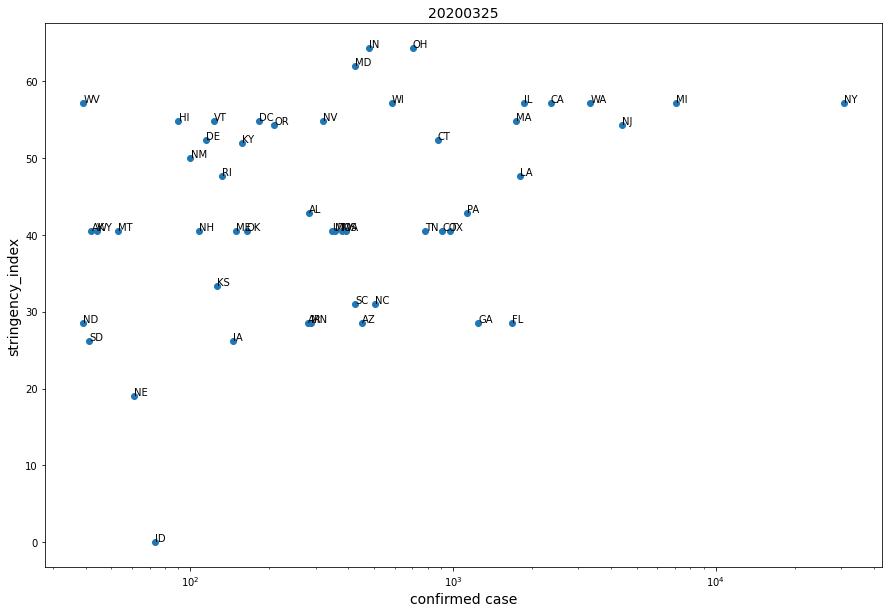

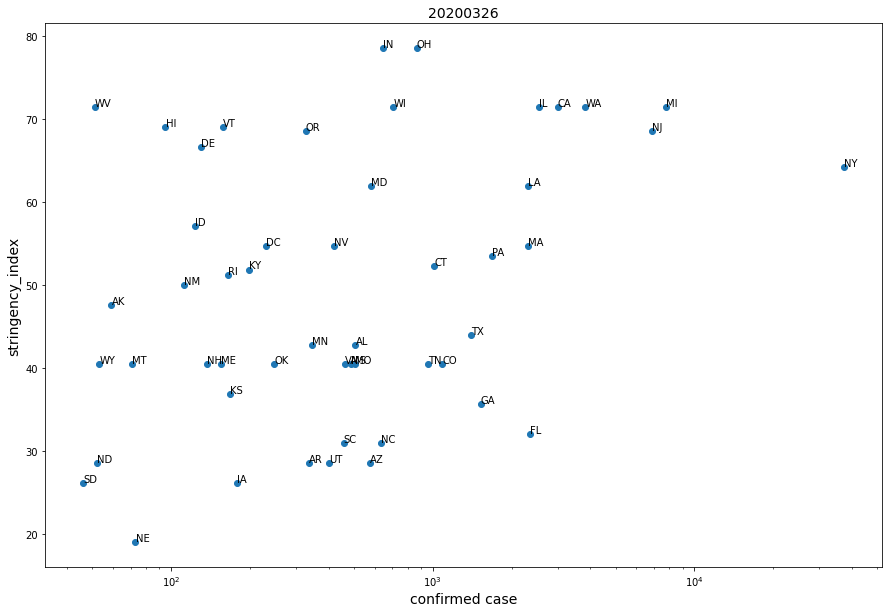

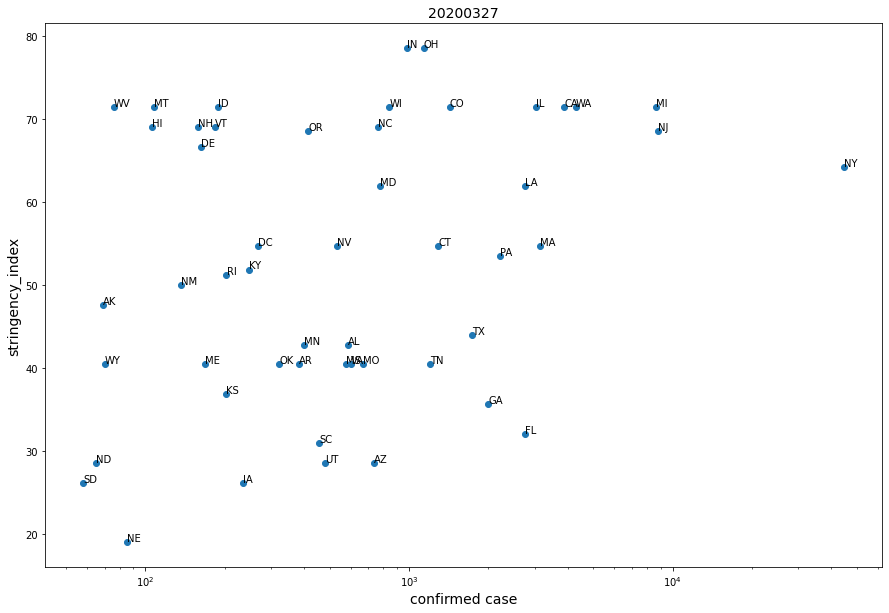

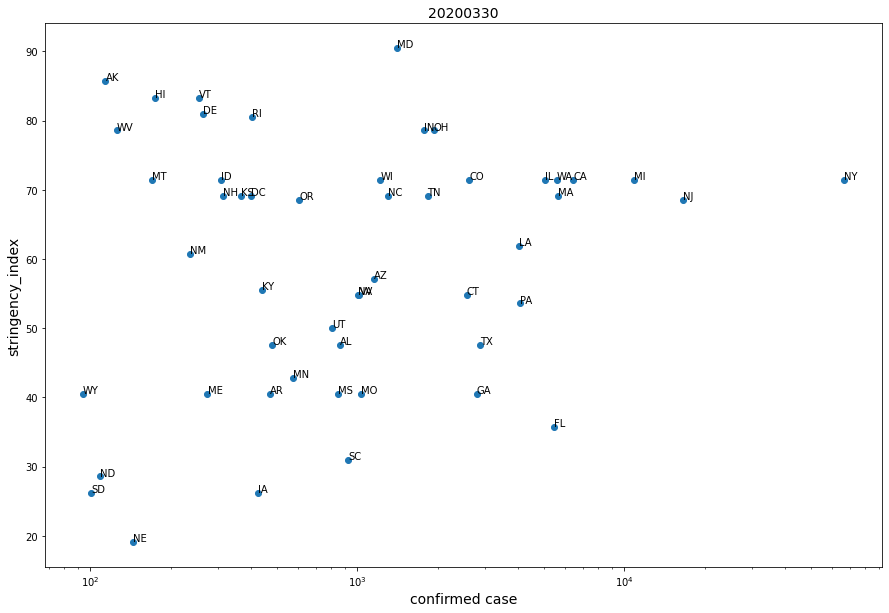

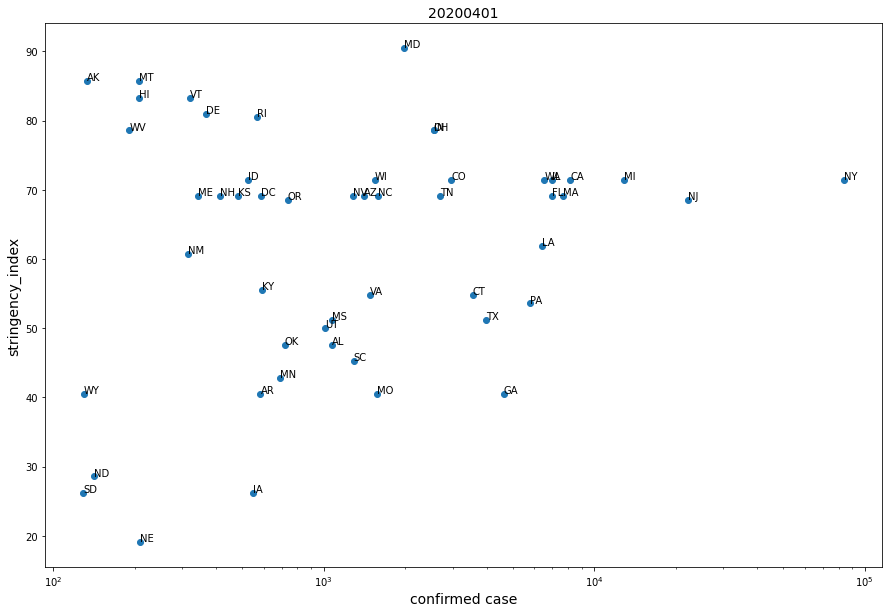

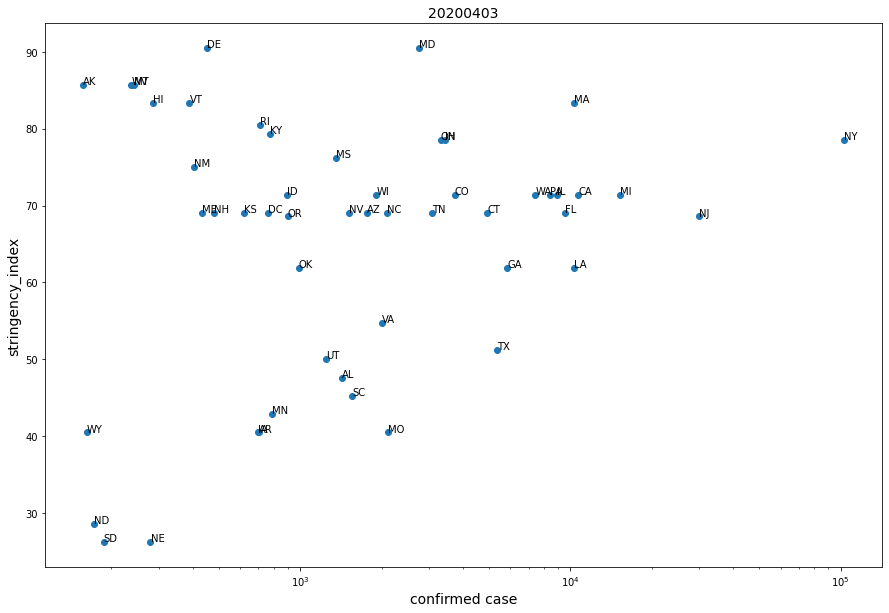

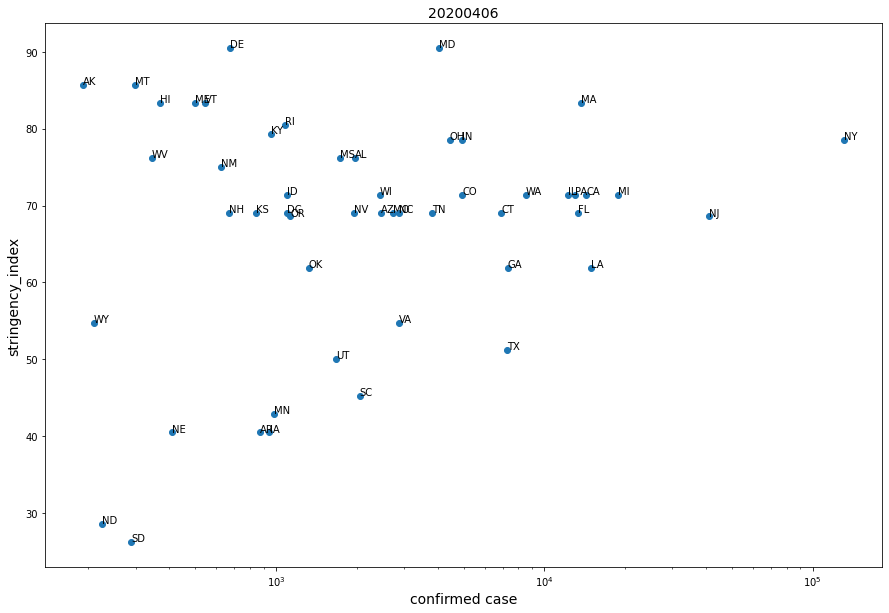

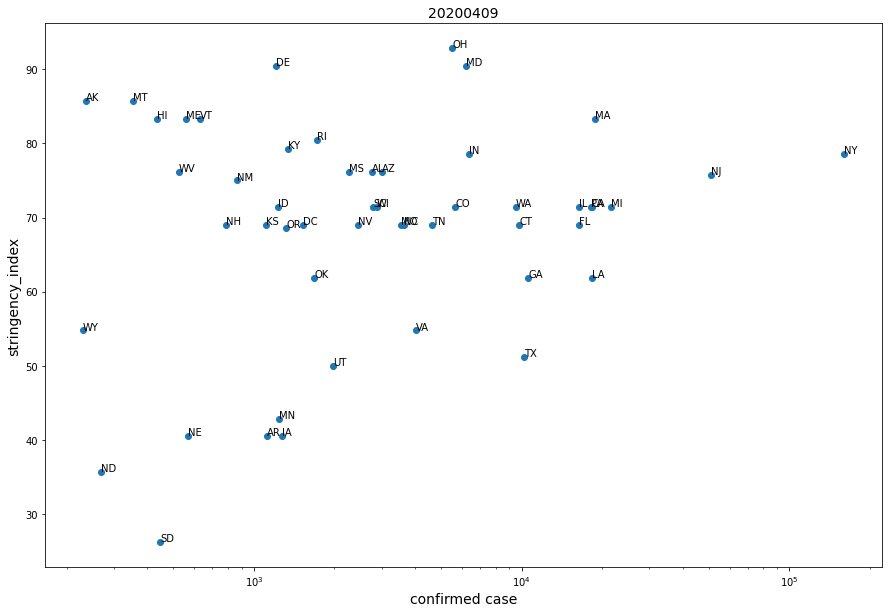

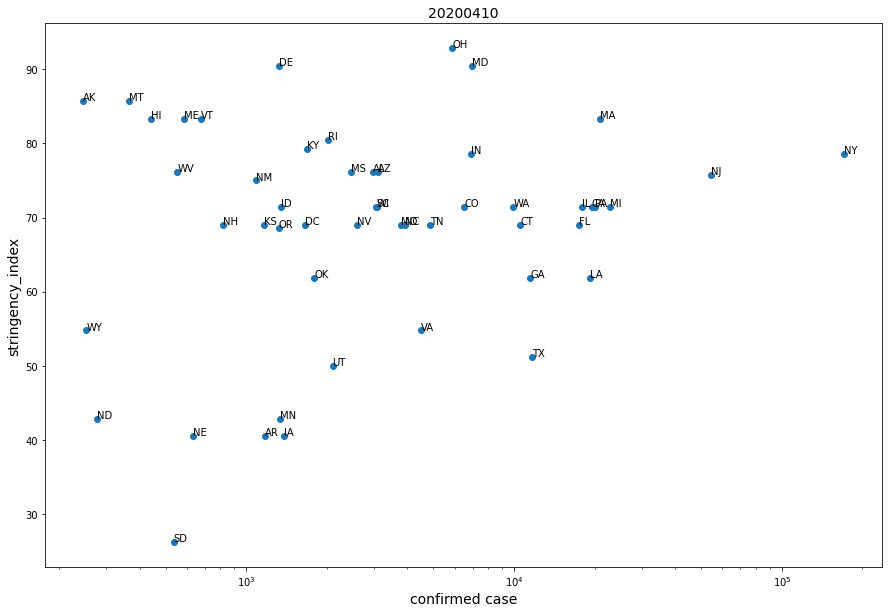

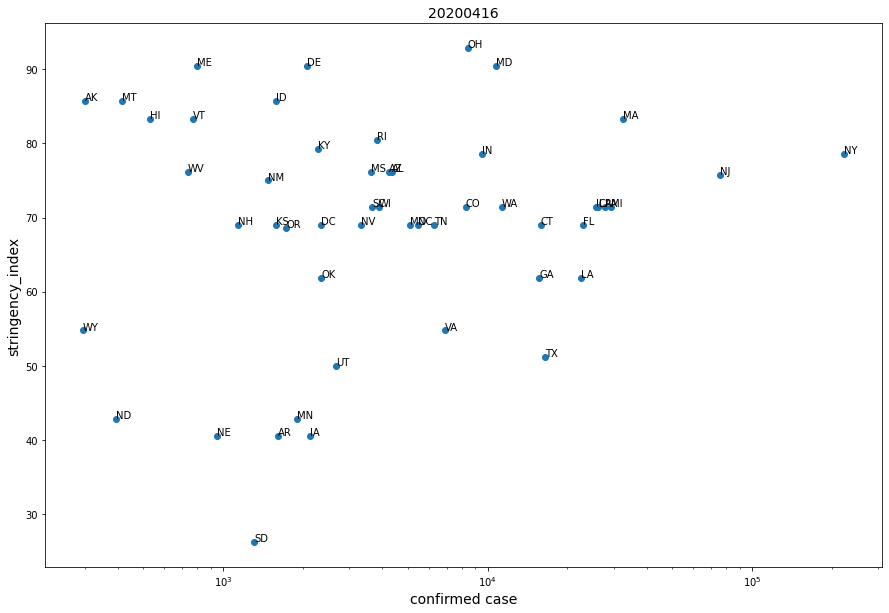

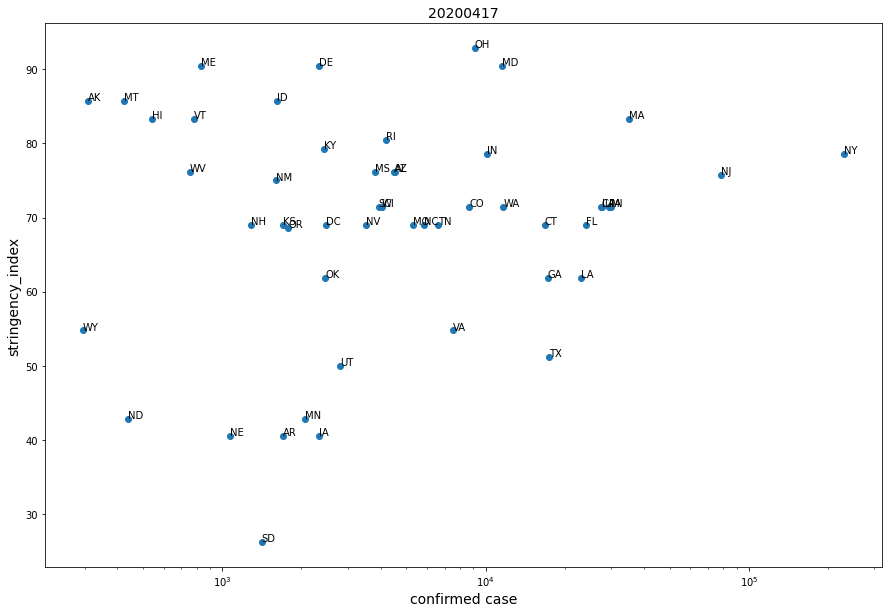

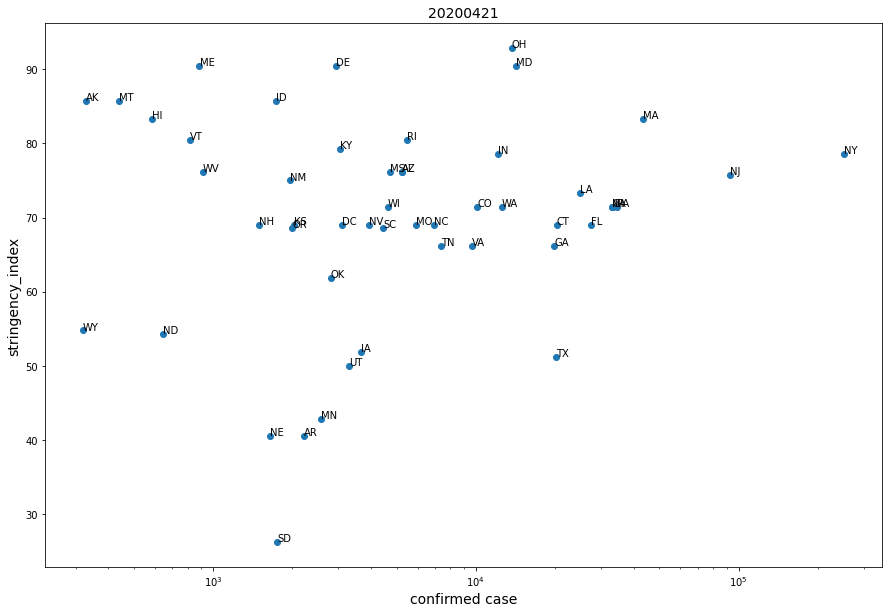

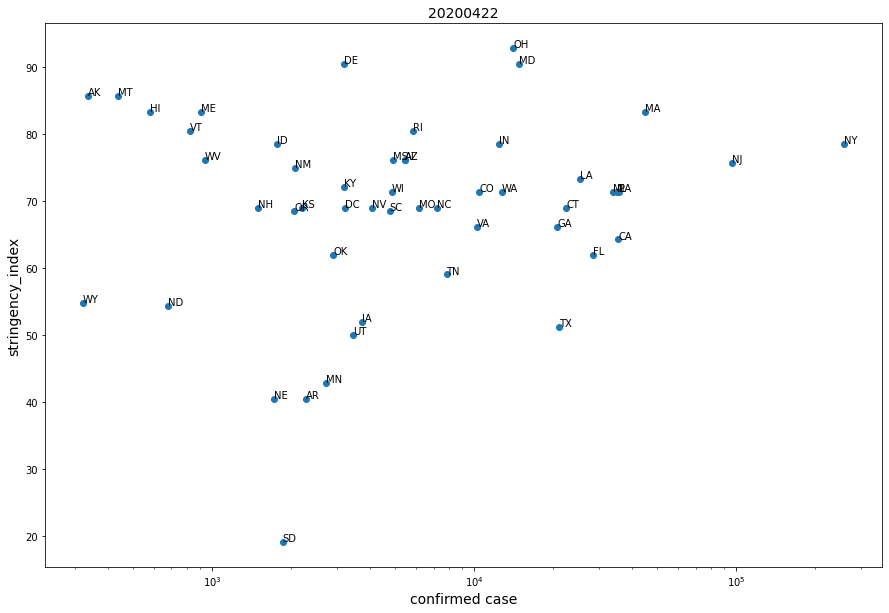

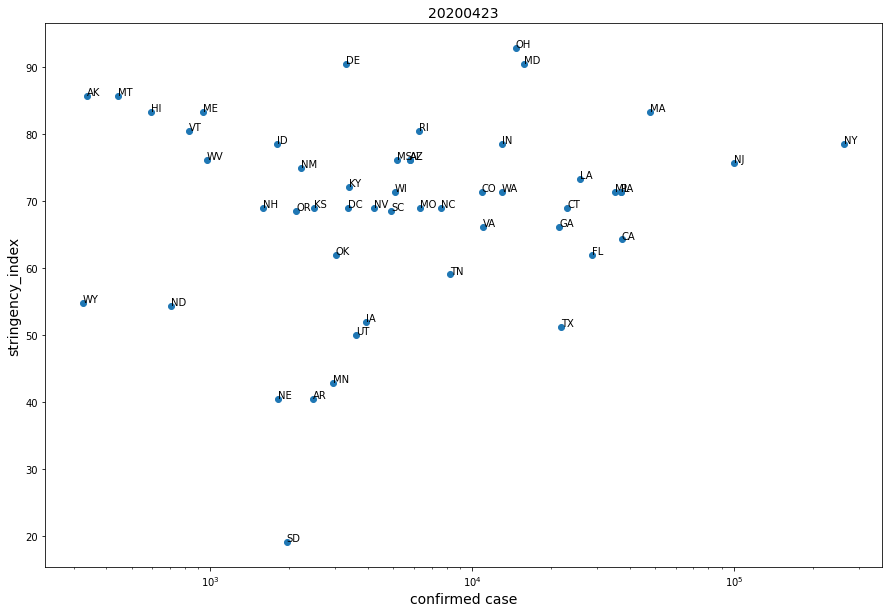

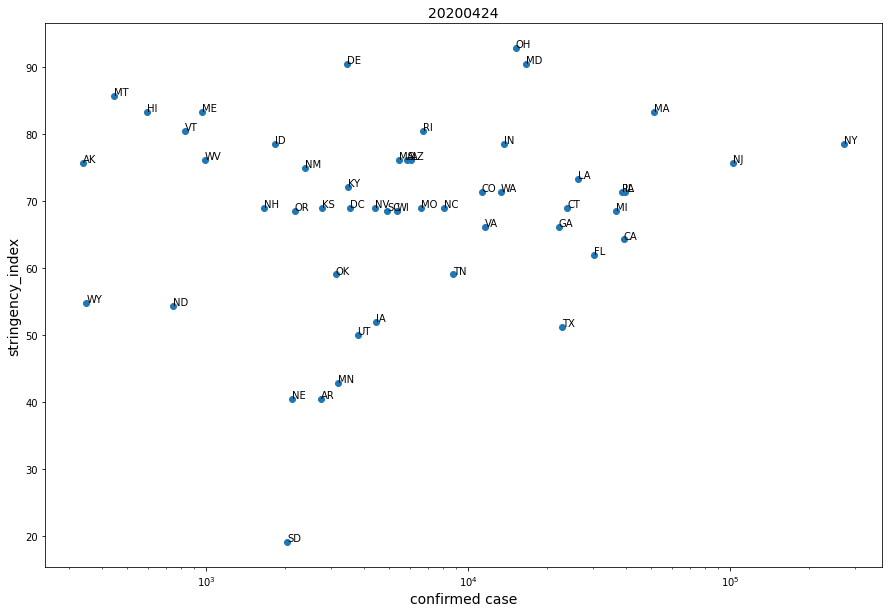

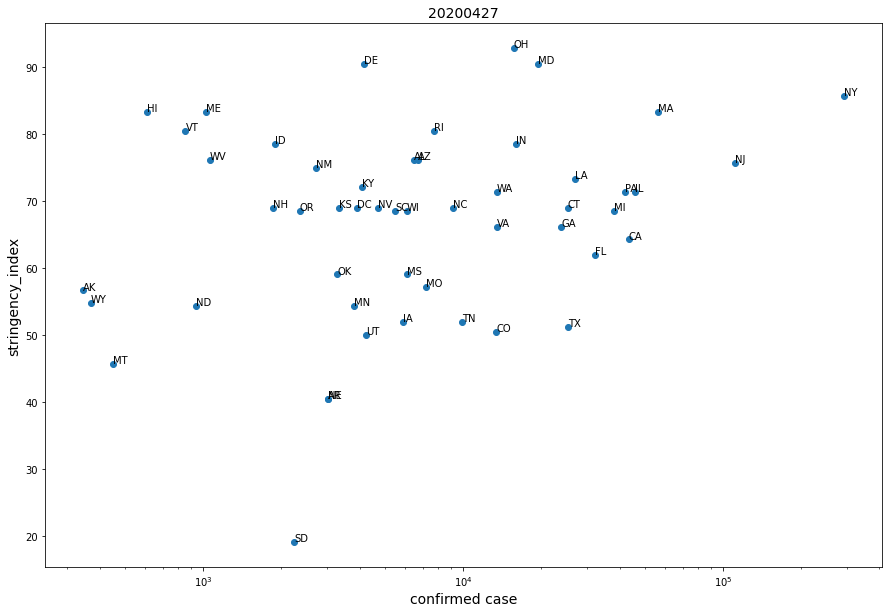

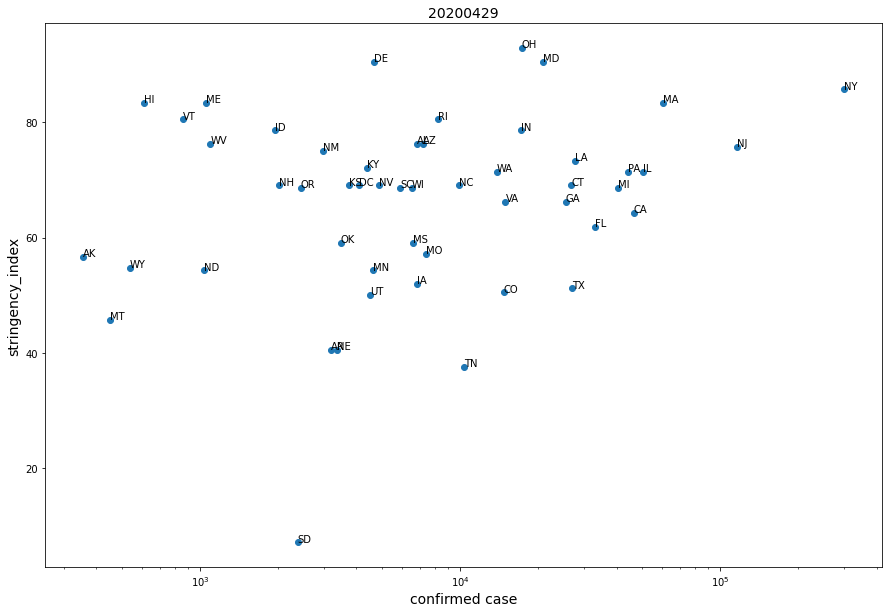

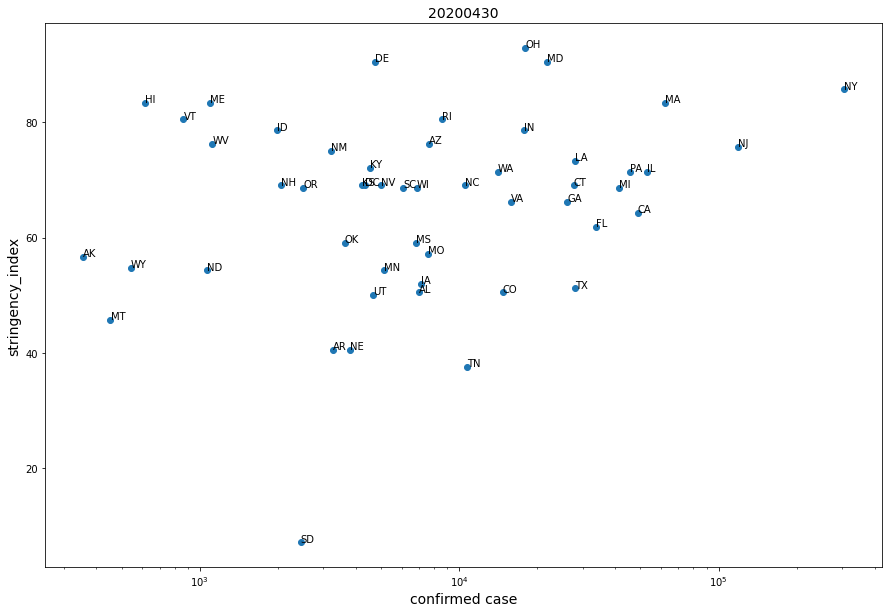

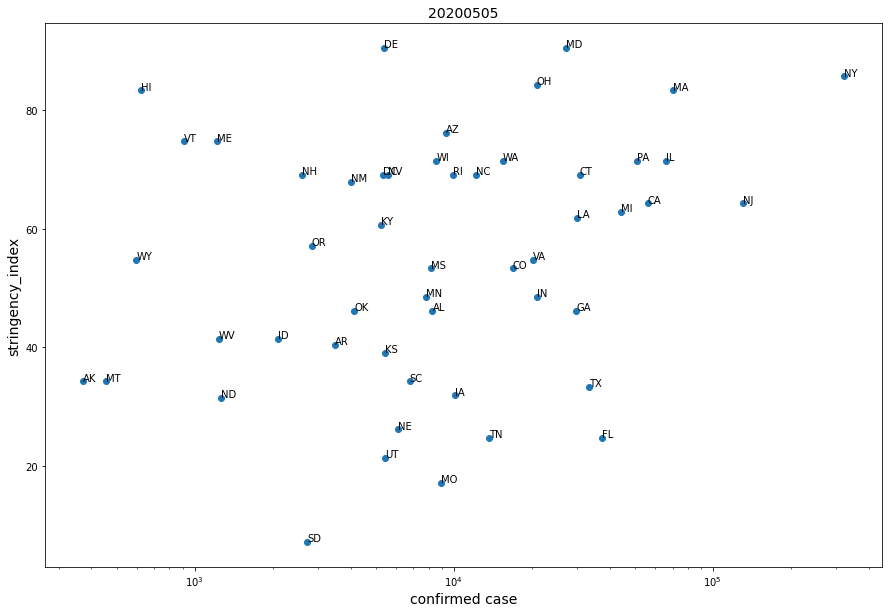

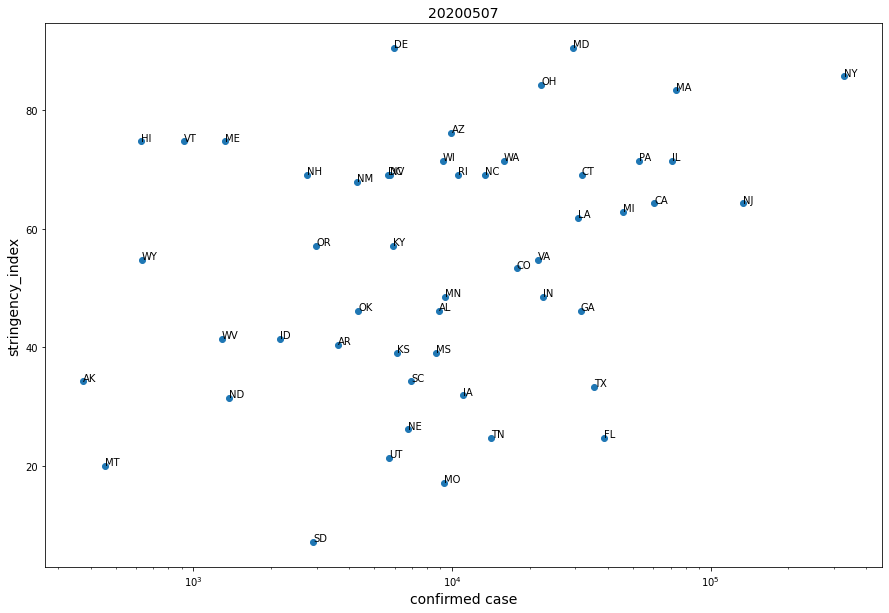

In [46]:
for i in range(len(filename_list)):
    x = state_index_merged[i]['confirmed']
    y = state_index_merged[i]['stringency_index']
    txt = state_index_merged[i]['state_code']

    plt.figure(num=3, figsize=(15, 10))       
    plt.scatter(x,y,s = 36)
    plt.ylabel('stringency_index', fontsize=14)
    plt.xlabel('confirmed case', fontsize=14)
    plt.xscale('log')
    plt.title(state_index_merged[i]['date'][0], fontsize=14)
    #m, b = np.polyfit(x, y, 1)
   # plt.plot(x, m*x + b)
 
   
    for j in range(len(x)):
        plt.annotate(txt[j], xy = (x[j], y[j]), xytext = (x[j]+0.1, y[j]+0.1))
    plt.savefig('./plots/state_index_date_merged_'+str(state_index_merged[i]['date'][0])+'.png')
    plt.show()    
    
    

In [55]:
state_date_index_merged=pd.concat(state_index_merged)
state_date_index_merged=state_date_index_merged[['date','state_name','stringency_index','confirmed']]
state_date_index_merged=state_date_index_merged.sort_values(by=['state_name','date'])

# write to output file in processed_data folder
state_date_index_merged.to_csv('./processed_data/state_date_index_merged.csv', index=False)
state_date_index_merged.head(3)


,date,state_name,stringency_index,confirmed
1,20200325,Alabama,42.857143,283.0
1,20200326,Alabama,42.857143,506.0
1,20200327,Alabama,42.857143,587.0


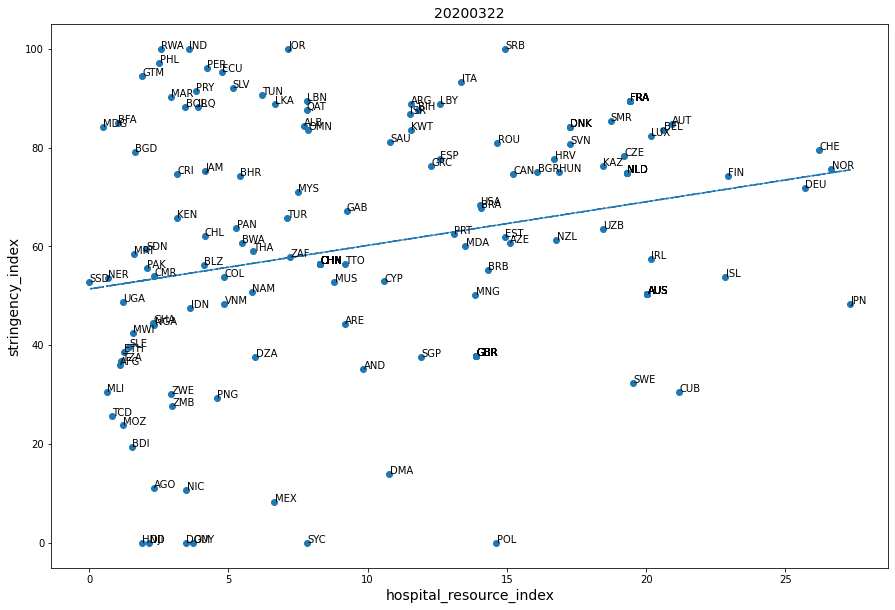

In [61]:
#Scatter figure for hospital resource and stringency index in country level
plt.figure(num=3, figsize=(15, 10))

data_frames = [country_policy_index[60],df_merged_country]

policy_hospital = reduce(lambda left, right: pd.merge(left, right, how='inner', on=['country_name']), data_frames)

y = policy_hospital['stringency_index']
y = y.fillna(0)
x = policy_hospital['hospital_resource_index']
txt = policy_hospital['country_code_x']

plt.scatter(x,y,s = 36)
plt.xlabel('hospital_resource_index', fontsize=14)
plt.ylabel('stringency_index', fontsize=14)
plt.title(policy_hospital['date'][0], fontsize=14)
for i in range(len(x)):
    plt.annotate(txt[i], xy = (x[i], y[i]), xytext = (x[i]+0.01, y[i]+0.01))
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, '-.')
plt.savefig('./plots/country_hospital_stringency_'+str(policy_hospital['date'][0])+'.png')
plt.show() 



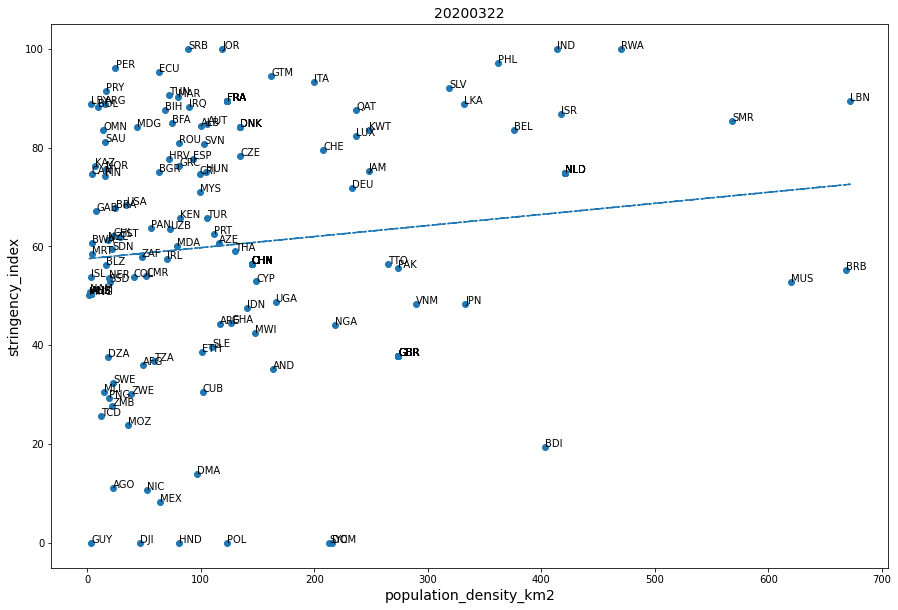

In [62]:
#Scatter figure for population density and stringency index in country level
plt.figure(num=3, figsize=(15, 10))  

data_frames = [country_policy_index[60],df_merged_country]
policy_hospital = reduce(lambda left, right: pd.merge(left, right, how='inner', on=['country_name']), data_frames)
policy_hospital = policy_hospital[~policy_hospital['country_code_x'].isin(['SGP'])]
policy_hospital = policy_hospital[~policy_hospital['country_code_x'].isin(['BHR'])]
policy_hospital = policy_hospital[~policy_hospital['country_code_x'].isin(['BGD'])]
policy_hospital = policy_hospital.reset_index(drop=True)
policy_hospital = policy_hospital.astype({'population_density_km2': 'float64'})
y = policy_hospital['stringency_index']
y = y.fillna(0)
x = policy_hospital['population_density_km2']
x = x.fillna(0)
txt = policy_hospital['country_code_x']
plt.scatter(x,y,s = 36)
plt.xlabel('population_density_km2', fontsize=14)
plt.ylabel('stringency_index', fontsize=14)
plt.title(policy_hospital['date'][0], fontsize=14)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, '-.')
for i in range(len(x)):
    plt.annotate(txt[i], xy = (x[i], y[i]), xytext = (x[i]+0.01, y[i]+0.01))
plt.savefig('./plots/country_pop_density_stringency_'+str(policy_hospital['date'][0])+'.png')
plt.show() 

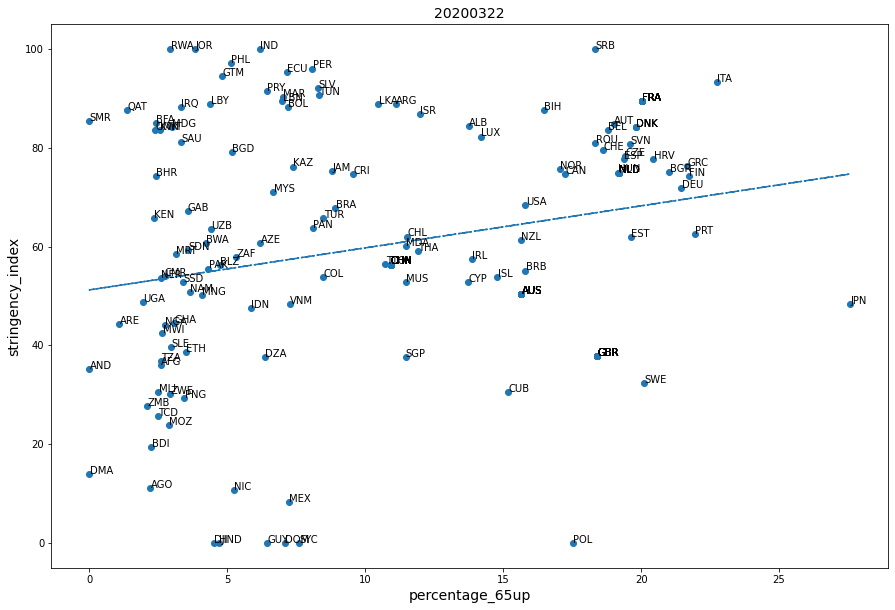

In [63]:
#Scatter figure for percentage of the elder and stringency index in country level
plt.figure(num=3, figsize=(15, 10))

data_frames = [country_policy_index[60],df_merged_country]

policy_hospital = reduce(lambda left, right: pd.merge(left, right, how='inner', on=['country_name']), data_frames)

y = policy_hospital['stringency_index']
y = y.fillna(0)
x = policy_hospital['percentage_65up']
txt = policy_hospital['country_code_x']
plt.scatter(x,y,s = 36)
plt.xlabel('percentage_65up', fontsize=14)
plt.ylabel('stringency_index', fontsize=14)
plt.title(policy_hospital['date'][0], fontsize=14)
for i in range(len(x)):
    plt.annotate(txt[i], xy = (x[i], y[i]), xytext = (x[i]+0.01, y[i]+0.01))
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, '-.')
plt.savefig('./plots/country_elder_stringency_'+str(policy_hospital['date'][0])+'.png')
plt.show() 

In [51]:
df_merged['hospital_resource_index'] =  df_merged['hospitals_per_1000']*10 + df_merged['icu_beds_per_1000']

df_merged.head(3)

,state_name,state_code,hospitals_per_1000,icu_beds_per_1000,percentage_60up,state_population,population_density_km2,hospital_resource_index
0,Alabama,AL,0.017523,0.316032,21.968157,4850771,37,0.491262
1,Alaska,AK,0.029787,0.161123,15.847894,738565,0,0.458998
2,Arizona,AZ,0.010720,0.228930,22.066078,6809946,23,0.336126


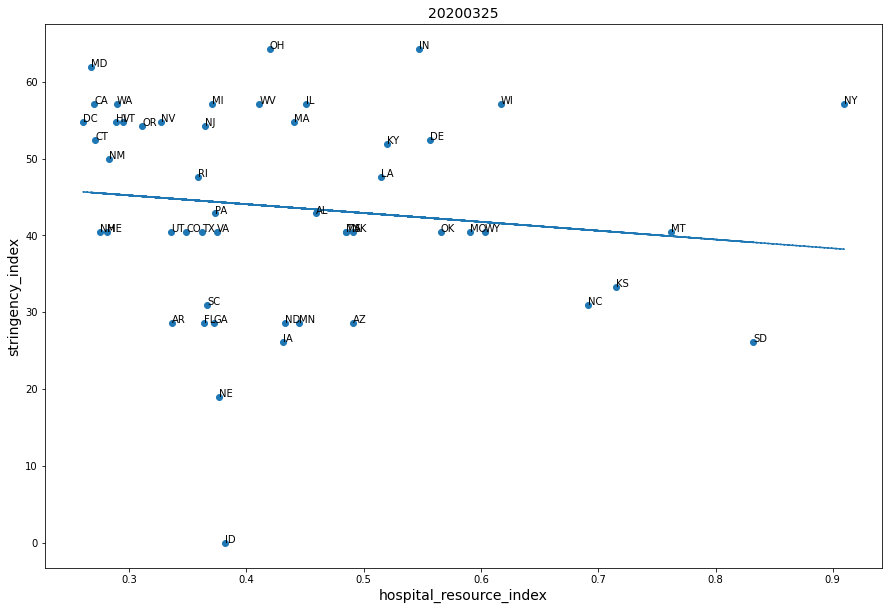

In [60]:
#Scatter figure for hospital resource and stringency index in state level
plt.figure(num=3, figsize=(15, 10))  
y = state_index_merged[0]['stringency_index']
x = df_merged['hospital_resource_index']
txt = state_index_merged[0]['state_code']

plt.scatter(x,y,s = 36)
plt.xlabel('hospital_resource_index', fontsize=14)
plt.ylabel('stringency_index', fontsize=14)
plt.title(state_index_merged[0]['date'][0], fontsize=14)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, '-.')
for i in range(len(x)):
    plt.annotate(txt[i], xy = (x[i], y[i]), xytext = (x[i], y[i]))
plt.savefig('./plots/state_hospital_stringency_'+str(state_index_merged[0]['date'][0])+'.png')
plt.show()  


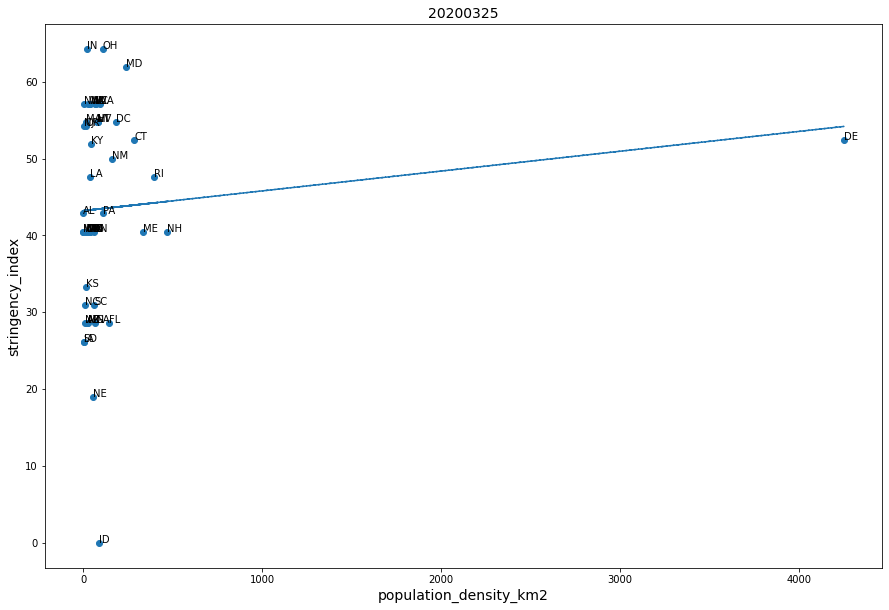

In [64]:
#Scatter figure for population density and stringency index in state level
plt.figure(num=3, figsize=(15, 10))  
y = state_index_merged[0]['stringency_index']
x = df_merged['population_density_km2']
txt = state_index_merged[0]['state_code']

plt.scatter(x,y,s = 36)
plt.xlabel('population_density_km2', fontsize=14)
plt.ylabel('stringency_index', fontsize=14)
plt.title(state_index_merged[0]['date'][0], fontsize=14)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, '-.')
for i in range(len(x)):
    plt.annotate(txt[i], xy = (x[i], y[i]), xytext = (x[i]+0.01, y[i]+0.01))
plt.savefig('./plots/state_pop_density_stringency_'+str(state_index_merged[0]['date'][0])+'.png')
plt.show() 

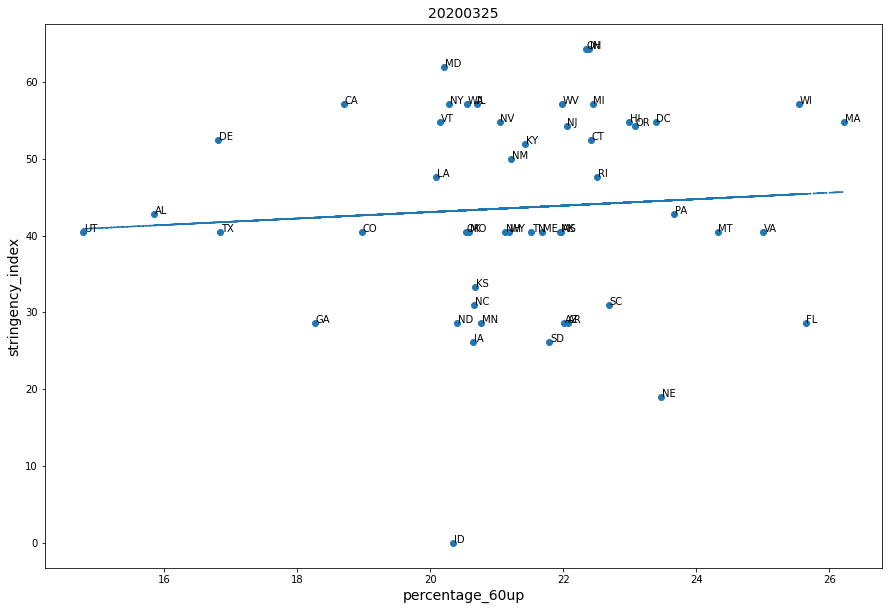

In [65]:
##Scatter figure for percentage of the elder and stringency index in country level
plt.figure(num=3, figsize=(15, 10))  
y = state_index_merged[0]['stringency_index']
x = df_merged['percentage_60up']
txt = state_index_merged[0]['state_code']

plt.scatter(x,y,s = 36)
plt.xlabel('percentage_60up', fontsize=14)
plt.ylabel('stringency_index', fontsize=14)
plt.title(state_index_merged[0]['date'][0], fontsize=14)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, '-.')
for i in range(len(x)):
    plt.annotate(txt[i], xy = (x[i], y[i]), xytext = (x[i]+0.01, y[i]+0.01))
plt.savefig('./plots/state_elder_stringency_'+str(state_index_merged[0]['date'][0])+'.png')
plt.show() 